In [1]:
cd ..

/Users/jibanmac/Documents/GitHub/matter_emu_dgmgp


In [2]:
from typing import Optional

from matter_multi_fidelity_emu.data_loader_dgmgp import interpolate

In [3]:
import os

from matter_multi_fidelity_emu.plottings.validation_loader import ValidationLoader
from matter_multi_fidelity_emu.data_loader import folder_name


from examples.make_plots_pipeline import PreloadedVloaders



In [4]:
import numpy as np
import h5py
import json
import glob
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# change some plotting defaults
# plt.rc('xtick',labelsize=26)
# plt.rc('ytick',labelsize=26)
# plt.rcParams['xtick.major.size'] = 8
# plt.rcParams['xtick.major.width'] = 1.5
# plt.rcParams['xtick.minor.size'] = 5
# plt.rcParams['xtick.minor.width'] = 1.25
# plt.rcParams['ytick.major.size'] = 8
# plt.rcParams['ytick.major.width'] = 1.5
# plt.rcParams['ytick.minor.size'] = 5
# plt.rcParams['ytick.minor.width'] = 1.25
# plt.rcParams['axes.linewidth'] = 2
matplotlib.rcParams.update(
    {"font.size": 16, "axes.labelsize": 24, "axes.titlesize": 18, "text.usetex": True,
    "xtick.major.width": 1.5, "xtick.minor.width": 1.2, "ytick.major.width": 1.5, "ytick.minor.width": 1.2,
    "legend.fontsize": 18}
)

# colors to use
c_flatirons = '#8B2131'
c_sunshine = '#CA9500'
c_skyline = '#1D428A'
c_midnight = '#0E2240'

colors = [c_flatirons, c_sunshine, c_skyline, c_midnight]

# acronym
mf_box = "MF-Box"

# useful throughout
base_dir = '/Users/jibanmac/Documents/GitHub/matter_emu_dgmgp/data/'
emudir = '/Users/jibanmac/Documents/GitHub/matter_emu_dgmgp/data/dmo_60_res128box256/'
imgdir = '/Users/jibanmac/Documents/Latex/mf_boxsize_paper/images/'
zz = np.array([0, 0.2, 0.5, 1.0, 2.0, 3.0])
test = h5py.File(emudir+'cc_emulator_powerspecs.hdf5', 'r')
kf_test = test['kfmpc'][:]
test.close()

## Collect emulation results from various emulators



In [5]:
# Let's follow Martin's convention and organize the necessary emulators to one variable
# Note: I used to run more emulators than necessary, so I have to specify the folders I want to read
# instead of reading everything in the based_dir

In [6]:
vloaders = PreloadedVloaders()

 /Users/jibanmac/Documents/GitHub/matter_emu_dgmgp/matter_multi_fidelity_emu/plottings/validation_loader.py:149: RuntimeWarning:overflow encountered in power
 /Users/jibanmac/Documents/GitHub/matter_emu_dgmgp/matter_multi_fidelity_emu/plottings/validation_loader.py:133: RuntimeWarning:invalid value encountered in divide


In [7]:
np.abs(vloaders.ar1_H3_slice19.pred_div_exact - 1).shape

(9, 10, 96)

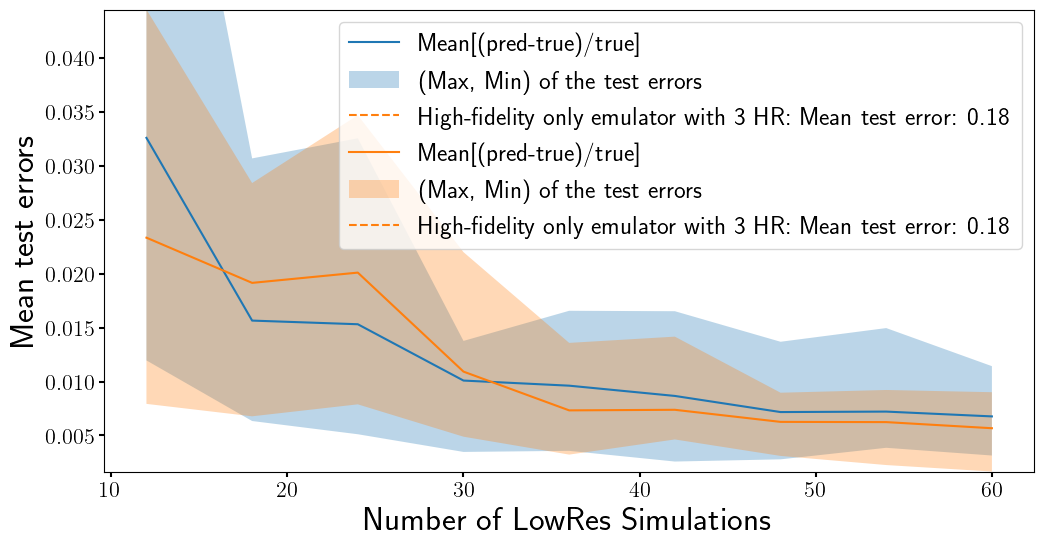

In [8]:
plt.figure(figsize=(12, 6))
vloaders.ar1_H3_slice19.plot_average_test_errors();
vloaders.dgmgp_H3_slice19.plot_average_test_errors();

In [9]:
vloaders.dgmgp_H3_slice19.relative_errors.shape

(9, 10, 95)

### Functions for plotting averaged errors

In [10]:
# currently using std of |prediction/truth - 1| for uncertainty
# to propagate from prediction uncertainty (error):
# error/prediction * |prediction/truth - 1| / N


def get_mean_std(vloader: ValidationLoader, ):
    """
    A modification from Martin's plotting script
    """
    absmean = np.mean(vloader.relative_errors, axis=2)
    absstd  = np.std( vloader.relative_errors, axis=2)

    absmeanHF = np.mean(vloader.relative_errors_hf, axis=2)
    absstdHF  = np.std( vloader.relative_errors_hf, axis=2)

    return absmean, absstd, absmeanHF, absstdHF


In [11]:

# get error for a specific emulator (averaged over z or k)
def get_mean_std_one(lf: Optional[int], hf: Optional[int], z_or_k: str = 'k', nargp: bool = False):
    """
    Modification from Martin's function

    Parameters:
    ----
    lf : number of LF points
    HF : number of HF points
    z_or_k : errors as function of z or k, i.e., average over k or z
    nargp : use nargp results or ar1 results
    """
    axis_z = 0
    axis_test_cases = 1
    axis_k = 2

    if not nargp:
        folder_fn = ar1_folder_name
    elif nargp:
        folder_fn = nargp_folder_name

    # TODO: fix these for now
    res_l = 128
    res_h = 512
    box_l = 256
    box_h = 256
    z = [0, 0.2, 0.5, 1.0, 2.0, 3.0]
    slice = [57, 58, 59]
    num_lf = lf
    num_hf = hf
    
    # list of emulators in different redshifts
    vloader = ValidationLoader(
        [
            folder_fn(num_lf, res_l, box_l, num_hf, res_h, box_h, zz, slice) for zz in z
        ],
        num_lowres_list=[num_lf for _ in z],
        num_highres=num_hf,
    )
    vloader.res_l = res_l
    vloader.res_h = res_h
    vloader.box_l = box_l
    vloader.box_h = box_h
    vloader.z     = z 
    vloader.slice = slice
    vloader.num_lf = num_lf
    vloader.num_hf = num_hf

    # average over k
    # pred_div_exact: Shape (number of emulators (redshifts in this case), number of test simulations, number of k bins)
    if z_or_k == 'z':
        absmean = np.full(absmean.shape[axis_z], fill_value=np.nan)
        absstd  = np.full(absmean.shape[axis_z], fill_value=np.nan)
        for i in enumerate(absmean):
            absmean[i] = np.mean(np.abs(vloader.pred_div_exact - 1)[i, :, :])
            absstd[i]  = np.std( np.abs(vloader.pred_div_exact - 1)[i, :, :])

    elif z_or_k == 'k':
        absmean = np.full(absmean.shape[axis_k], fill_value=np.nan)
        absstd  = np.full(absmean.shape[axis_k], fill_value=np.nan)
        for i in enumerate(absmean):
            absmean[i] = np.mean(np.abs(vloader.pred_div_exact - 1)[:, :, i])
            absstd[i]  = np.std( np.abs(vloader.pred_div_exact - 1)[:, :, i])

    return vloader, absmean, absstd


### Plot examples of flux power spectrum

In [42]:
def interp_lf_trim_hf(k_lf: np.ndarray, k_hf: np.ndarray, Y_lf: np.ndarray, Y_hf: np.ndarray):
    # Interpolate the LF,
    # and limit the HF kmax to the maximum of LF
    # Min k bins LF <= k bins HF <= Max k bins LF
    ind_min = (np.log10(k_lf).min() <= np.log10(k_hf)) & (
        np.log10(k_hf) <= np.log10(k_lf).max()
    )

    # interpolate: interp(log10_k, Y_lf)(log10_k[ind_min])
    # I do want to interpolate in loglog scale.
    # TODO: Think about if our smooth prior is on linear or log scale?
    Y_lf_new = interpolate(
        np.log10(k_lf), np.log10(Y_lf), np.log10(k_hf)[ind_min]
    )
    Y_lf = 10**Y_lf_new
    Y_hf = Y_hf[:, ind_min]
    k_hf = k_hf[ind_min]
    k_lf = k_hf

    return k_lf, k_hf, Y_lf, Y_hf, ind_min

96 89 89
[Info] rebin powerspecs from 89 k bins to 96 k bins.
117 89 89
[Info] rebin powerspecs from 89 k bins to 117 k bins.
96 89 89
[Info] rebin powerspecs from 89 k bins to 96 k bins.
117 89 89
[Info] rebin powerspecs from 89 k bins to 117 k bins.
96 89 89
[Info] rebin powerspecs from 89 k bins to 96 k bins.
117 89 89
[Info] rebin powerspecs from 89 k bins to 117 k bins.
96 89 89
[Info] rebin powerspecs from 89 k bins to 96 k bins.
117 89 89
[Info] rebin powerspecs from 89 k bins to 117 k bins.
96 89 89
[Info] rebin powerspecs from 89 k bins to 96 k bins.
117 89 89
[Info] rebin powerspecs from 89 k bins to 117 k bins.
96 89 89
[Info] rebin powerspecs from 89 k bins to 96 k bins.
117 89 89
[Info] rebin powerspecs from 89 k bins to 117 k bins.
96 89 89
[Info] rebin powerspecs from 89 k bins to 96 k bins.
117 89 89
[Info] rebin powerspecs from 89 k bins to 117 k bins.


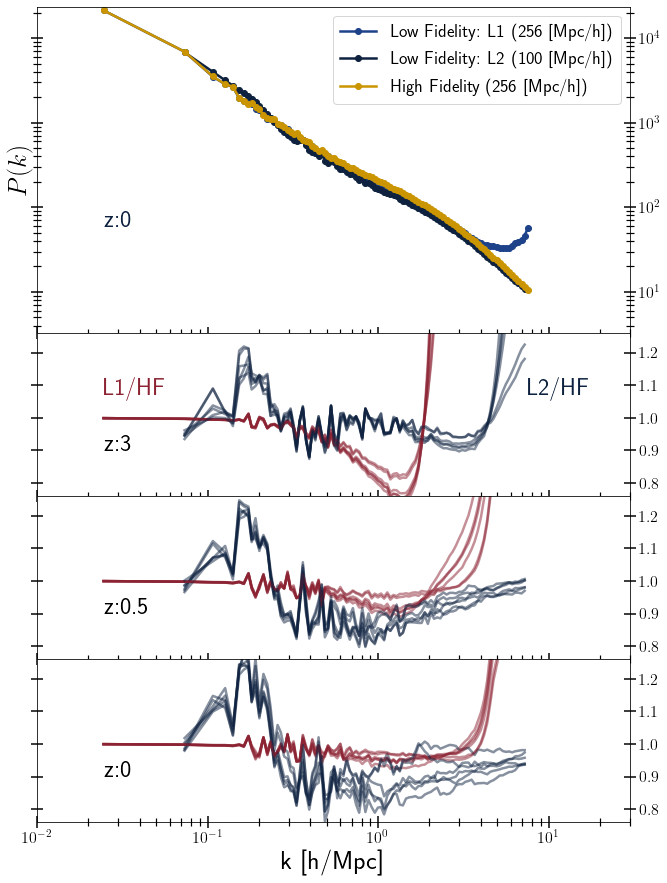

In [43]:
# plot the difference between HF and LF for each simulation pair available

# lores, hires indices: 0:18, 1:4, 2:17, 3:36, 4:26, 5:1
hires = h5py.File('data/dmo_24_res512box256/cc_emulator_powerspecs.hdf5', 'r')
hrfp, hrkf = hires['powerspecs'][:], hires['kfmpc'][:]
hires.close()

lores = h5py.File('data/dmo_60_res128box256/cc_emulator_powerspecs.hdf5', 'r')
lrfp, lrkf = lores['powerspecs'][:], lores['kfmpc'][:]
lores.close()

lores_2 = h5py.File('data/dmo_60_res128box100/cc_emulator_powerspecs.hdf5', 'r')
lrfp_2, lrkf_2 = lores_2['powerspecs'][:], lores_2['kfmpc'][:]
lores_2.close()


# make interpolation to make sure lr and hr have the same shape
## Start here
## -------------
axis_redshift = 1
num_redshifts = hrfp.shape[axis_redshift]

# L1 and HF
this_lrkf, this_hrkf, this_lrfp, this_hrfp, ind = interp_lf_trim_hf(
    k_lf=lrkf, k_hf=hrkf, Y_lf=lrfp[:, 0, :], Y_hf=hrfp[:, 0, :]
)
hrfp_new = np.full((this_hrfp.shape[0], num_redshifts, len(this_hrkf)), fill_value=np.nan)
lrfp_new = np.full((this_lrfp.shape[0], num_redshifts, len(this_lrkf)), fill_value=np.nan)

# L2 node
this_lrkf_2, this_hrkf_2, this_lrfp_2, this_hrfp_2, ind = interp_lf_trim_hf(
    k_lf=lrkf_2, k_hf=hrkf, Y_lf=lrfp_2[:, 0, :], Y_hf=hrfp[:, 0, :],
)
lrfp_new_2 = np.full((this_lrfp_2.shape[0], num_redshifts, len(this_lrkf_2)), fill_value=np.nan)
hrfp_new_2 = np.full((this_hrfp_2.shape[0], num_redshifts, len(this_hrkf_2)), fill_value=np.nan)


for i in range(num_redshifts):
    # L1 and H
    this_lrkf, this_hrkf, this_lrfp, this_hrfp, ind = interp_lf_trim_hf(
        k_lf=lrkf, k_hf=hrkf, Y_lf=lrfp[:, i, :], Y_hf=hrfp[:, i, :],
    )
    hrfp_new[:, i, :] = this_hrfp
    lrfp_new[:, i, :] = this_lrfp

    # L2 and H
    this_lrkf_2, this_hrkf_2, this_lrfp_2, this_hrfp_2, ind = interp_lf_trim_hf(
        k_lf=lrkf_2, k_hf=hrkf, Y_lf=lrfp_2[:, i, :], Y_hf=hrfp[:, i, :],
    )
    hrfp_new_2[:, i, :] = this_hrfp_2
    lrfp_new_2[:, i, :] = this_lrfp_2


lrfp = lrfp_new
hrfp = hrfp_new

lrkf = this_lrkf
hrkf = this_hrkf

# L2
lrfp_2 = lrfp_new_2
hrfp_2 = hrfp_new_2

lrkf_2 = this_lrkf_2
hrkf_2 = this_hrkf_2


## finish inpterpolation
## End here
## -------------

xr = [0.02, 9]
yr = [0.76, 1.26]
fig, ax = plt.subplots(
    figsize=(10.625, 3*5), nrows=4, ncols=1, sharex=True, gridspec_kw={'height_ratios': [2, 1, 1, 1]}
)
plt.setp(ax, ylim=yr, xlim=xr)

# plot the top panel -- example flux power for LF and HF
z   = 0 # index of the redshift
ith = 0 # ith training simulation pair LF/HF

# Count L2 only until max k of L1
ind = lrkf_2 < lrkf.max()

ax[0].loglog(lrkf,   lrfp[ith, z, :],   'o-', c=c_skyline,  lw=2.5, label="Low Fidelity: L1 (256 [Mpc/h])")
ax[0].loglog(lrkf_2[ind], lrfp_2[ith, z, :][ind], 'o-', c=c_midnight, lw=2.5, label="Low Fidelity: L2 (100 [Mpc/h])")
ax[0].loglog(hrkf,   hrfp[ith, z, :],   'o-', c=c_sunshine, lw=2.5, label="High Fidelity (256 [Mpc/h])")

# ax[0].text(hrkf.min() * 1.5, hrfp.max() * .5, 'High Fidelity', c=c_sunshine, fontsize=22)
# ax[0].text(lrkf.min() * 1.2, lrfp.max() * .1, 'Low Fidelity', c=c_skyline, fontsize=22)
ax[0].text(lrkf.min(), lrfp.max() * 2e-3, 'z:'+str(zz[z]), c=c_midnight, fontsize=24)

ax[0].set_ylabel(r'$P(k)$', fontsize=26)
ax[0].set_yscale('log')
ax[0].set_ylim([lrfp[ith, z, :].min()*0.1, lrfp[ith, z, :].max()*1.1])
ax[0].set_xlim([0.01, 30])
ax[0].legend()

ax[0].tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)
ax[0].tick_params(which='minor', length=8, labelright=False, labelleft=False)



# plot the lower panels -- LF/HF for all pairs
j = 1
for z in np.array([5,2,0]): #z = 3, 0.5, 0
    for i in range(6):
        # L1 - HF
        ax[j].plot(lrkf, lrfp[i, z, :]/hrfp[i, z, :], '-', c=c_flatirons, lw=2.5, alpha=0.5)

        # L2 - HF
        ax[j].plot(lrkf_2[ind], lrfp_2[i, z, :][ind] / hrfp_2[i, z, :][ind], '-', c=c_midnight, lw=2.5, alpha=0.5)

    ax[j].text(lrkf.min(), 0.9, 'z:'+str(zz[z]), fontsize=24)

    ax[j].tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)
    ax[j].tick_params(which='minor', length=8, labelright=False, labelleft=False)
    j += 1

ax[1].text(lrkf.min(), 1.07, 'L1/HF', c=c_flatirons, fontsize=24) 
ax[1].text(lrkf.max(), 1.07, 'L2/HF', c=c_midnight, fontsize=24) 

ax[3].set_xlabel('k [h/Mpc]', fontsize=26)
fig.patch.set_facecolor('none')
fig.subplots_adjust(hspace=0, wspace=0)

# fig.savefig("/home/jibancat/Documents/Latex/mf_boxsize_paper/images/power_comp.pdf",
#             bbox_inches='tight', pad_inches=0.075)
plt.show()

### Plot of mean error broken down by scale (across all tests, fixed z) versus number of training simulations

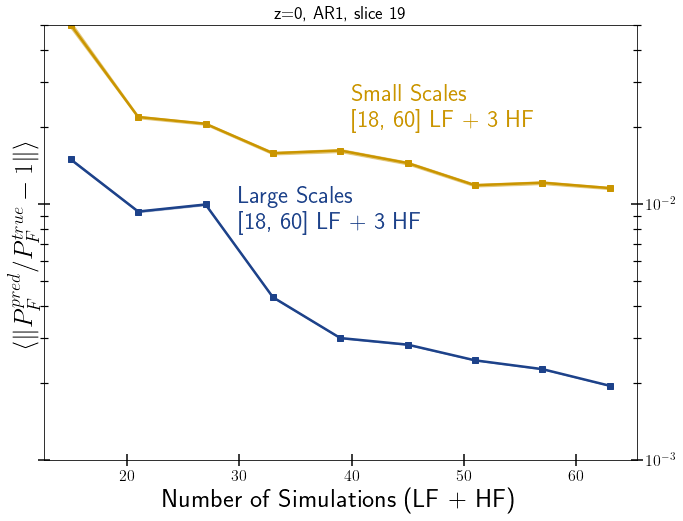

In [13]:
# error with number of training simulations (across all sims, split into small/large scales)
vloader = vloaders.ar1_H3_slice19  # vary LF
# vloader_H369 = vloaders.ar1_H3_6_9 # vary HF

k_pivot = 1

# ind_smallH = 10**vloader_H369.kf[0] >= k_pivot
# ind_largeH = 10**vloader_H369.kf[0] < k_pivot

ind_smallL = 10**vloader.kf[0] >= k_pivot
ind_largeL = 10**vloader.kf[0] < k_pivot

fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

## Large scales
## Start here
## --------------
#
# Shape (number of emulators, number of test points, number of k bins)
# absmeanHF = np.array([
#     np.mean(error[:, ind_largeH]) for error in vloader_H369.relative_errors
# ])
# absstdHF  = np.array([
#     np.std(error[:, ind_largeH]) for error in vloader_H369.relative_errors
# ])

absmeanLF = np.array([
    np.mean(error[:, ind_largeL]) for error in vloader.relative_errors
])
absstdLF  = np.array([
    np.std(error[:, ind_largeL]) for error in vloader.relative_errors
])

ax.plot(
    np.array(vloader.num_lf) + vloader.num_hf,
    absmeanLF,
    's-',
    c=c_skyline,
    lw=2.5
)
# plot variance instead of std
ax.fill_between(
    np.array(vloader.num_lf) + vloader.num_hf,
    (absmeanLF-absstdLF**2),
    (absmeanLF+absstdLF**2),
    color=c_skyline,
    alpha=0.4
)


# ax.plot(
#     np.array(vloader_H369.num_hf) + vloader_H369.num_lf[0],
#     absmeanHF, 's--', c=c_skyline, lw=2.5
# )


## Small scales
## Start here
## --------------
#
# Shape (number of emulators, number of test points, number of k bins)
# absmeanHF = np.array([
#     np.mean(error[:, ind_smallH]) for error in vloader_H369.relative_errors
# ])
# absstdHF  = np.array([
#     np.std(error[:, ind_smallH]) for error in vloader_H369.relative_errors
# ])

absmeanLF = np.array([
    np.mean(error[:, ind_smallL]) for error in vloader.relative_errors
])
absstdLF  = np.array([
    np.std(error[:, ind_smallL]) for error in vloader.relative_errors
])


ax.plot(
    np.array(vloader.num_lf) + vloader.num_hf,
    absmeanLF,
    's-',
    c=c_sunshine,
    lw=2.5
)
# plot variance instead of std
ax.fill_between(
    np.array(vloader.num_lf) + vloader.num_hf,
    (absmeanLF-absstdLF**2),
    (absmeanLF+absstdLF**2),
    color=c_sunshine,
    alpha=0.4
)

# ax.plot(
#     np.array(vloader_H369.num_hf) + vloader_H369.num_lf[0],
#     absmeanHF, 's--', c=c_sunshine, lw=2.5
# )

ax.text(30, 8e-3, 'Large Scales \n [18, 60] LF + 3 HF', c=c_skyline, fontsize=24)
ax.text(40, 2e-2, 'Small Scales \n [18, 60] LF + 3 HF', fontsize=24, c=c_sunshine)
# ax.text(50, 3e-2, 'Dashed \n 60 LF + [3, 9] HF', fontsize=24, c=c_midnight)

ax.set_xlabel('Number of Simulations (LF + HF)', fontsize=26)
ax.set_ylabel(r'$\langle\| P_F^{{pred}}/P_F^{{true}} - 1 \|\rangle$', fontsize=26)
ax.set_yscale('log')
ax.set_ylim([1e-3, 5e-2])
# ax.set_xlim([6, 45])
ax.tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)
ax.tick_params(which='minor', length=8, labelright=False, labelleft=False)
ax.patch.set_facecolor('none')

ax.set_title("z=0, AR1, slice 19")

fig.subplots_adjust(hspace=0, wspace=0)
fig.savefig("/home/jibancat/Documents/Latex/mf_boxsize_paper/images/ar1_H3_slice19_nsim_scales_error.pdf", bbox_inches='tight', pad_inches=0.075)
plt.show()

In [14]:
def make_scale_split_versus_LF(
    vloader: ValidationLoader, k_pivot: float, new_fig: bool = False, ax=None, fig=None,
    **kwargs
):

    ind_smallL = 10**vloader.kf[0] >= k_pivot
    ind_largeL = 10**vloader.kf[0] < k_pivot

    if new_fig:
        fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

    ## Large scales
    ## Start here
    ## --------------
    absmeanLF = np.array([
        np.mean(error[:, ind_largeL]) for error in vloader.relative_errors
    ])
    absstdLF  = np.array([
        np.std(error[:, ind_largeL]) for error in vloader.relative_errors
    ])

    ax.plot(
        np.array(vloader.num_lf) + vloader.num_hf,
        absmeanLF,
        's-',
        c=c_skyline,
        lw=2.5,
        **kwargs
    )
    # plot variance instead of std
    ax.fill_between(
        np.array(vloader.num_lf) + vloader.num_hf,
        (absmeanLF-absstdLF**2),
        (absmeanLF+absstdLF**2),
        color=c_skyline,
        alpha=0.4
    )


    ## Small scales
    ## Start here
    ## --------------
    absmeanLF = np.array([
        np.mean(error[:, ind_smallL]) for error in vloader.relative_errors
    ])
    absstdLF  = np.array([
        np.std(error[:, ind_smallL]) for error in vloader.relative_errors
    ])


    ax.plot(
        np.array(vloader.num_lf) + vloader.num_hf,
        absmeanLF,
        's-',
        c=c_sunshine,
        lw=2.5,
        **kwargs
    )
    # plot variance instead of std
    ax.fill_between(
        np.array(vloader.num_lf) + vloader.num_hf,
        (absmeanLF-absstdLF**2),
        (absmeanLF+absstdLF**2),
        color=c_sunshine,
        alpha=0.4
    )
    
    return fig, ax


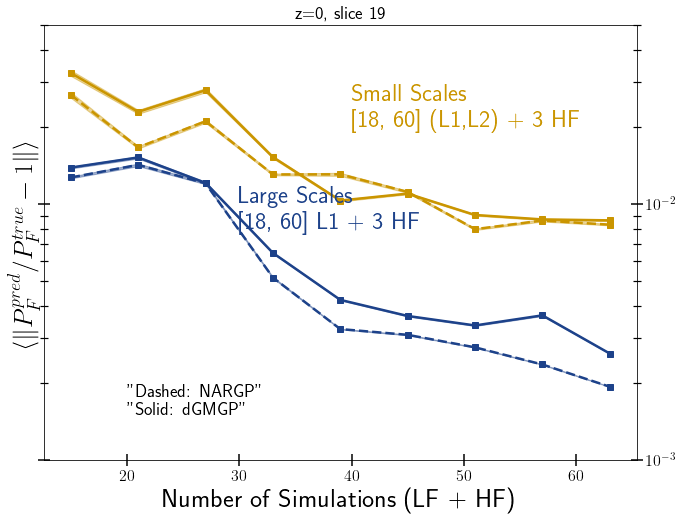

In [15]:
# error with number of training simulations (across all sims, split into small/large scales)
vloader = vloaders.nargp_H3_slice19  # vary LF

k_pivot = 1


fig, ax = make_scale_split_versus_LF(vloaders.nargp_H3_slice19, k_pivot, new_fig=True, ls="--", )
fig, ax = make_scale_split_versus_LF(vloaders.dgmgp_H3_slice19, k_pivot, new_fig=False, ax=ax, fig=fig, )

ax.text(30, 8e-3, 'Large Scales \n [18, 60] L1 + 3 HF', c=c_skyline, fontsize=24)
ax.text(40, 2e-2, 'Small Scales \n [18, 60] (L1,L2) + 3 HF', fontsize=24, c=c_sunshine)
ax.text(20, 1.5e-3, '"Dashed: NARGP"\n"Solid: dGMGP"', fontsize=18, c="k")
# ax.text(50, 3e-2, 'Dashed \n 60 LF + [3, 9] HF', fontsize=24, c=c_midnight)

ax.set_xlabel('Number of Simulations (LF + HF)', fontsize=26)
ax.set_ylabel(r'$\langle\| P_F^{{pred}}/P_F^{{true}} - 1 \|\rangle$', fontsize=26)
ax.set_yscale('log')
ax.set_ylim([1e-3, 5e-2])
# ax.set_xlim([6, 45])
ax.tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)
ax.tick_params(which='minor', length=8, labelright=False, labelleft=False)
ax.patch.set_facecolor('none')

ax.set_title("z=0, slice 19")
# ax.legend(["Dashed: AR1", "Solid: NARGP"])

fig.subplots_adjust(hspace=0, wspace=0)
fig.savefig("/home/jibancat/Documents/Latex/mf_boxsize_paper/images/nargp_H3_slice19_nsim_scales_error.pdf", bbox_inches='tight', pad_inches=0.075)
plt.show()

### Mean errors versus HR points

In [14]:
def make_scale_split_versus_HF(
    vloader: ValidationLoader, k_pivot: float, new_fig: bool = False, ax=None, fig=None,
    **kwargs
):

    ind_smallL = 10**vloader.kf[0] >= k_pivot
    ind_largeL = 10**vloader.kf[0] < k_pivot

    if new_fig:
        fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

    ## Large scales
    ## Start here
    ## --------------
    absmeanLF = np.array([
        np.mean(error[:, ind_largeL]) for error in vloader.relative_errors
    ])
    absstdLF  = np.array([
        np.std(error[:, ind_largeL]) for error in vloader.relative_errors
    ])

    ax.plot(
        vloader.num_hf,
        absmeanLF,
        's-',
        c=c_skyline,
        lw=2.5,
        **kwargs
    )
    # plot variance instead of std
    ax.fill_between(
        vloader.num_hf,
        (absmeanLF-absstdLF**2),
        (absmeanLF+absstdLF**2),
        color=c_skyline,
        alpha=0.4
    )


    ## Small scales
    ## Start here
    ## --------------
    absmeanLF = np.array([
        np.mean(error[:, ind_smallL]) for error in vloader.relative_errors
    ])
    absstdLF  = np.array([
        np.std(error[:, ind_smallL]) for error in vloader.relative_errors
    ])


    ax.plot(
        vloader.num_hf,
        absmeanLF,
        's-',
        c=c_sunshine,
        lw=2.5,
        **kwargs
    )
    # plot variance instead of std
    ax.fill_between(
        vloader.num_hf,
        (absmeanLF-absstdLF**2),
        (absmeanLF+absstdLF**2),
        color=c_sunshine,
        alpha=0.4
    )

    return fig, ax


In [17]:
# TODO: another plot with varying HF points


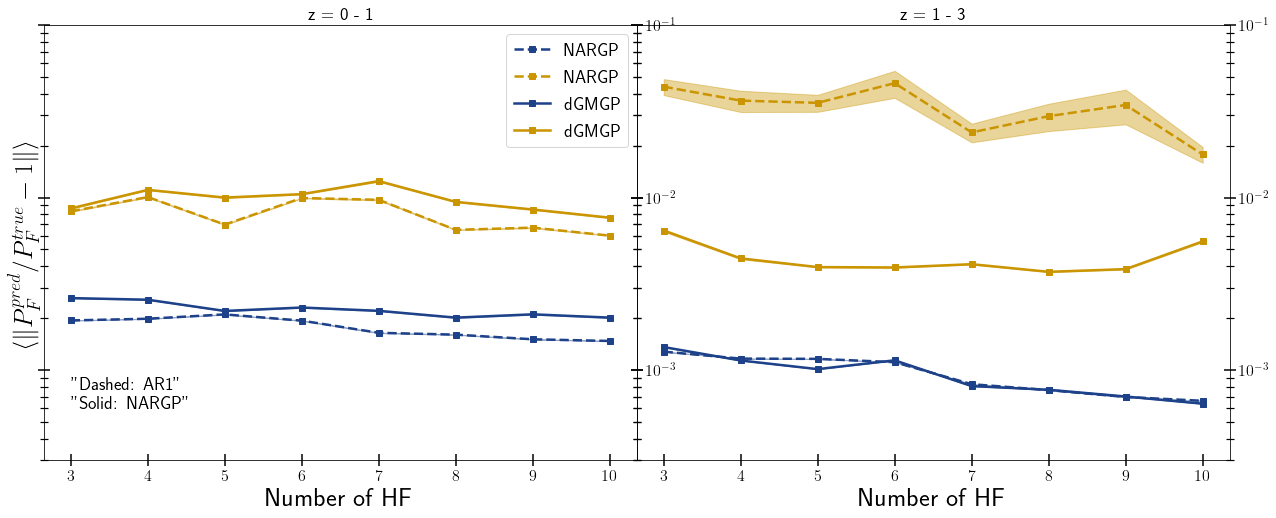

In [18]:
fig, axs = plt.subplots(figsize=(2*10.625, 8), nrows=1, ncols=2, sharey=True)

# error with number of training simulations (across all sims, split into small/large scales)
k_pivot = 1

fig, ax = make_scale_split_versus_HF(vloaders.nargp_L60_H3_10_z0, k_pivot, new_fig=False, ls="--", ax=axs[0], fig=fig, label="NARGP")
fig, ax = make_scale_split_versus_HF(vloaders.dgmgp_L60_H3_10_z0, k_pivot, new_fig=False, ax=ax, fig=fig, label="dGMGP")

fig, ax = make_scale_split_versus_HF(vloaders.nargp_L60_H3_10_z2, k_pivot, new_fig=False, ls="--", ax=axs[1], fig=fig)
fig, ax = make_scale_split_versus_HF(vloaders.dgmgp_L60_H3_10_z2, k_pivot, new_fig=False, ax=ax, fig=fig, )

# ax.text(30, 8e-3, 'Large Scales \n [18, 60] LF + 3 HF', c=c_skyline, fontsize=24)
# ax.text(40, 2e-2, 'Small Scales \n [18, 60] LF + 3 HF', fontsize=24, c=c_sunshine)
axs[0].text(3, 6e-4, '"Dashed: AR1"\n"Solid: NARGP"', fontsize=18, c="k")
# ax.text(50, 3e-2, 'Dashed \n 60 LF + [3, 9] HF', fontsize=24, c=c_midnight)

axs[0].set_xlabel('Number of HF', fontsize=26)
axs[0].set_ylabel(r'$\langle\| P_F^{{pred}}/P_F^{{true}} - 1 \|\rangle$', fontsize=26)
axs[0].set_yscale('log')
axs[0].set_ylim([3e-4, 1e-1])

axs[1].set_xlabel('Number of HF', fontsize=26)
# axs[1].set_ylabel(r'$\langle\| P_F^{{pred}}/P_F^{{true}} - 1 \|\rangle$', fontsize=26)
axs[1].set_yscale('log')
axs[1].set_ylim([3e-4, 1e-1])

axs[0].tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)
axs[0].tick_params(which='minor', length=8)

axs[1].tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)
axs[1].tick_params(which='minor', length=8)

axs[0].legend()
axs[0].set_title("z = 0 - 1")
axs[1].set_title("z = 1 - 3")

axs[0].patch.set_facecolor('none')
axs[1].patch.set_facecolor('none')
fig.subplots_adjust(hspace=0, wspace=0)
fig.savefig("/home/jibancat/Documents/Latex/mf_boxsize_paper/images/nargp_H3_slice19_HR_scales_error.pdf", bbox_inches='tight', pad_inches=0.075)
plt.show()

### Don't break down scales

In [15]:
def make_versus_HF(
    vloader: ValidationLoader, new_fig: bool = False, ax=None, fig=None,
    **kwargs
):

    if new_fig:
        fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

    ## Start here
    ## --------------
    absmeanLF = np.array([
        np.mean(error[:, :]) for error in vloader.relative_errors
    ])
    absstdLF  = np.array([
        np.std(error[:, :]) for error in vloader.relative_errors
    ])

    ax.plot(
        vloader.num_hf,
        absmeanLF,
        's-',
        lw=2.5,
        **kwargs
    )
    # plot variance instead of std
    ax.fill_between(
        vloader.num_hf,
        (absmeanLF-absstdLF**2),
        (absmeanLF+absstdLF**2),
        alpha=0.4
    )



    return fig, ax


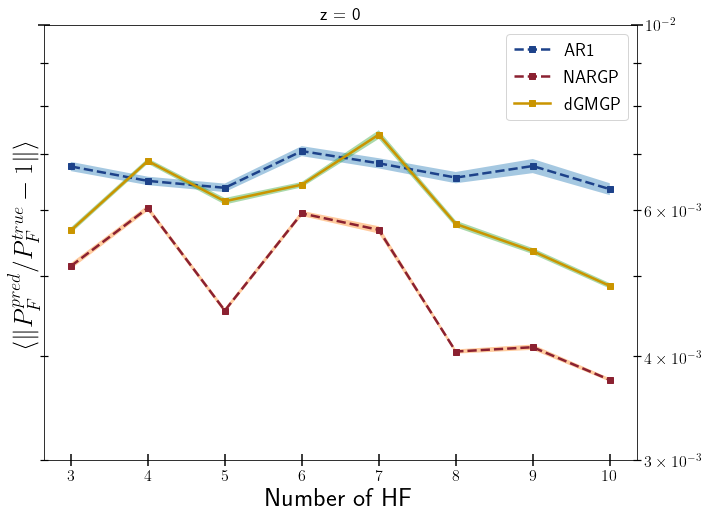

In [20]:
fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1, sharey=True)

# error with number of training simulations (across all sims, )
fig, ax = make_versus_HF(vloaders.ar1_L60_H3_10_z0, new_fig=False, ls="--", ax=ax, fig=fig, label="AR1", c=colors[2])
fig, ax = make_versus_HF(vloaders.nargp_L60_H3_10_z0, new_fig=False, ls="--", ax=ax, fig=fig, label="NARGP", c=colors[0])
fig, ax = make_versus_HF(vloaders.dgmgp_L60_H3_10_z0, new_fig=False, ax=ax, fig=fig, label="dGMGP", c=colors[1])

# ax.text(3, 6e-4, '"Dashed: AR1"\n"Solid: NARGP"', fontsize=18, c="k")
# ax.text(50, 3e-2, 'Dashed \n 60 LF + [3, 9] HF', fontsize=24, c=c_midnight)

ax.set_xlabel('Number of HF', fontsize=26)
ax.set_ylabel(r'$\langle\| P_F^{{pred}}/P_F^{{true}} - 1 \|\rangle$', fontsize=26)
ax.set_yscale('log')
ax.set_ylim([3e-3, 1e-2])

ax.tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)
ax.tick_params(which='minor', length=8)

ax.legend()
ax.set_title("z = 0")

ax.patch.set_facecolor('none')

fig.subplots_adjust(hspace=0, wspace=0)

fig.savefig("/home/jibancat/Documents/Latex/mf_boxsize_paper/images/nargp_H3_slice19_HR_error.pdf", bbox_inches='tight', pad_inches=0.075)
plt.show()

In [21]:
# TODO: another plot with sum over redshifts

### Break down the error by k bins (fixed k)

In [31]:
def make_average_all_z_versus_k(
    vloader: ValidationLoader, new_fig: bool = False, ax=None, fig=None, color="C0",
    zmin: float = 0.0, zmax: float = 3.1,
    **kwargs
):

    if new_fig:
        fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

    # Shape (number of zs, number of test points, number of k bins)        
    
    ## Large scales
    ## Start here
    ## --------------
    z = np.array(vloader.z)
    ind_z = (zmin <= z) & (z < zmax)
    absmeanLF = vloader.relative_errors[ind_z, :, :].mean(axis=(0, 1))
    absstdLF  = vloader.relative_errors[ind_z, :, :].std(axis=(0, 1))

    ax.semilogx(
        10**vloader.kf[0],
        absmeanLF,
        's-',
        lw=2.5,
        color=color,
        **kwargs
    )
    # plot variance instead of std
    ax.fill_between(
        10**vloader.kf[0],
        (absmeanLF-absstdLF**2),
        (absmeanLF+absstdLF**2),
        alpha=0.2,
        color=color,
    )

    return fig, ax


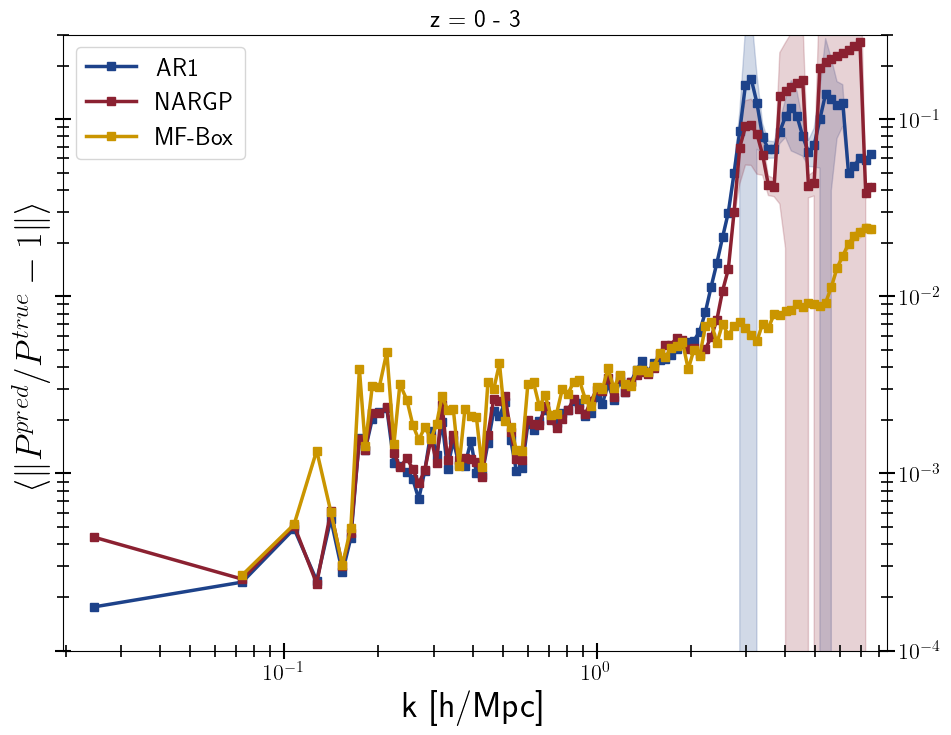

In [8]:
fig, ax = make_average_all_z_versus_k(
    vloaders.ar1_L60_H3_z0_1_2_slice_19,
    new_fig=True,
    color=colors[2],
    label="AR1",
)
fig, ax = make_average_all_z_versus_k(
    vloaders.nargp_L60_H3_z0_1_2_slice_19,
    new_fig=False,
    color=colors[0],
    label="NARGP",
    ax=ax,
    fig=fig,    
)

# MFBOX
fig, ax = make_average_all_z_versus_k(
    vloaders.dgmgp_L60_H3_z0_1_2_slice_19,
    new_fig=False,
    color=colors[1],
    label=mf_box,
    ax=ax,
    fig=fig,
)


# Martin style
ax.set_xlabel(r'k [h/Mpc]', fontsize=26)
ax.set_ylabel(r'$\langle\| P^{{pred}}/P^{{true}} - 1 \|\rangle$', fontsize=26)
ax.set_yscale('log')
ax.set_ylim([1e-4, 3e-1])
ax.set_xlim([kf_test.min()* 0.8, kf_test.max() * 1.1])

ax.tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)
ax.tick_params(which='minor', length=8)

ax.legend()
ax.set_title("z = 0 - 3")

ax.patch.set_facecolor('none')
fig.subplots_adjust(hspace=0, wspace=0)
fig.savefig(
    os.path.join(imgdir, "dgmgp_all_z_versus_k.pdf"),
    bbox_inches='tight',
    pad_inches=0.075
)
plt.show()

### Proposal Plot (z = 0)

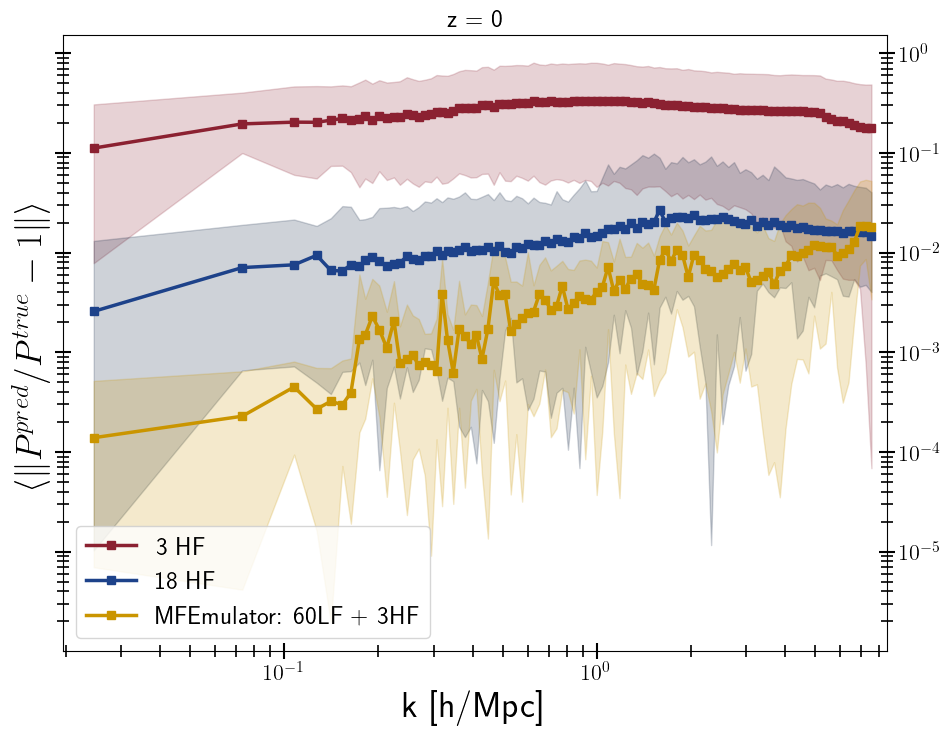

In [58]:
fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

# 3 HF only
vloader = vloaders.nargp_L60_L2box100_H3_z0_1_2_slice_0_1_2

absmeanLF     = vloader.relative_errors_hf[[0], :, :].mean(axis=(0, 1))
absstdLF_min  = vloader.relative_errors_hf[[0], :, :].min(axis=(0, 1))
absstdLF_max  = vloader.relative_errors_hf[[0], :, :].max(axis=(0, 1))

ax.semilogx(
    10**vloader.kf[0],
    absmeanLF,
    's-',
    lw=2.5,
    color=colors[0],
    label="3 HF"
)
# plot variance instead of std
ax.fill_between(
    10**vloader.kf[0],
    absstdLF_min,
    absstdLF_max,
    alpha=0.2,
    color=colors[0],
)

# 18 HF only
vloader = vloaders.ar1_H18_slice19

absmeanLF     = vloader.relative_errors_hf[:, :, :].mean(axis=(0, 1))
absstdLF_min  = vloader.relative_errors_hf[:, :, :].min(axis=(0, 1))
absstdLF_max  = vloader.relative_errors_hf[:, :, :].max(axis=(0, 1))


ax.semilogx(
    10**vloader.kf[0],
    absmeanLF,
    's-',
    lw=2.5,
    color=colors[2],
    label="18 HF"
)
# plot variance instead of std
ax.fill_between(
    10**vloader.kf[0],
    absstdLF_min,
    absstdLF_max,
    alpha=0.2,
    color=colors[3],
)


# MFEmulator : 60-3

vloader = vloaders.nargp_L60_H3_z0_1_2_slice_19

absmeanLF     = vloader.relative_errors[[0], :, :].mean(axis=(0, 1))
absstdLF_min  = vloader.relative_errors[[0], :, :].min(axis=(0, 1))
absstdLF_max  = vloader.relative_errors[[0], :, :].max(axis=(0, 1))

ax.semilogx(
    10**vloader.kf[0],
    absmeanLF,
    's-',
    lw=2.5,
    color=colors[1],
    label="MFEmulator: 60LF + 3HF"
)
# plot variance instead of std
ax.fill_between(
    10**vloader.kf[0],
    absstdLF_min,
    absstdLF_max,
    alpha=0.2,
    color=colors[1],
)


# Martin style
ax.set_xlabel(r'k [h/Mpc]', fontsize=26)
ax.set_ylabel(r'$\langle\| P^{{pred}}/P^{{true}} - 1 \|\rangle$', fontsize=26)
ax.set_yscale('log')
# ax.set_ylim([1e-4, 3e-1])
ax.set_xlim([kf_test.min()* 0.8, kf_test.max() * 1.1])

ax.tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)
ax.tick_params(which='minor', length=8)

ax.legend()
ax.set_title("z = 0 ")

ax.patch.set_facecolor('none')
fig.subplots_adjust(hspace=0, wspace=0)
fig.savefig(
    os.path.join("../../Latex/postdoc_app_2022/images/", "MF_proposal_past.pdf"),
    bbox_inches='tight',
    pad_inches=0.075
)
plt.show()

### Break down into different redshift bins

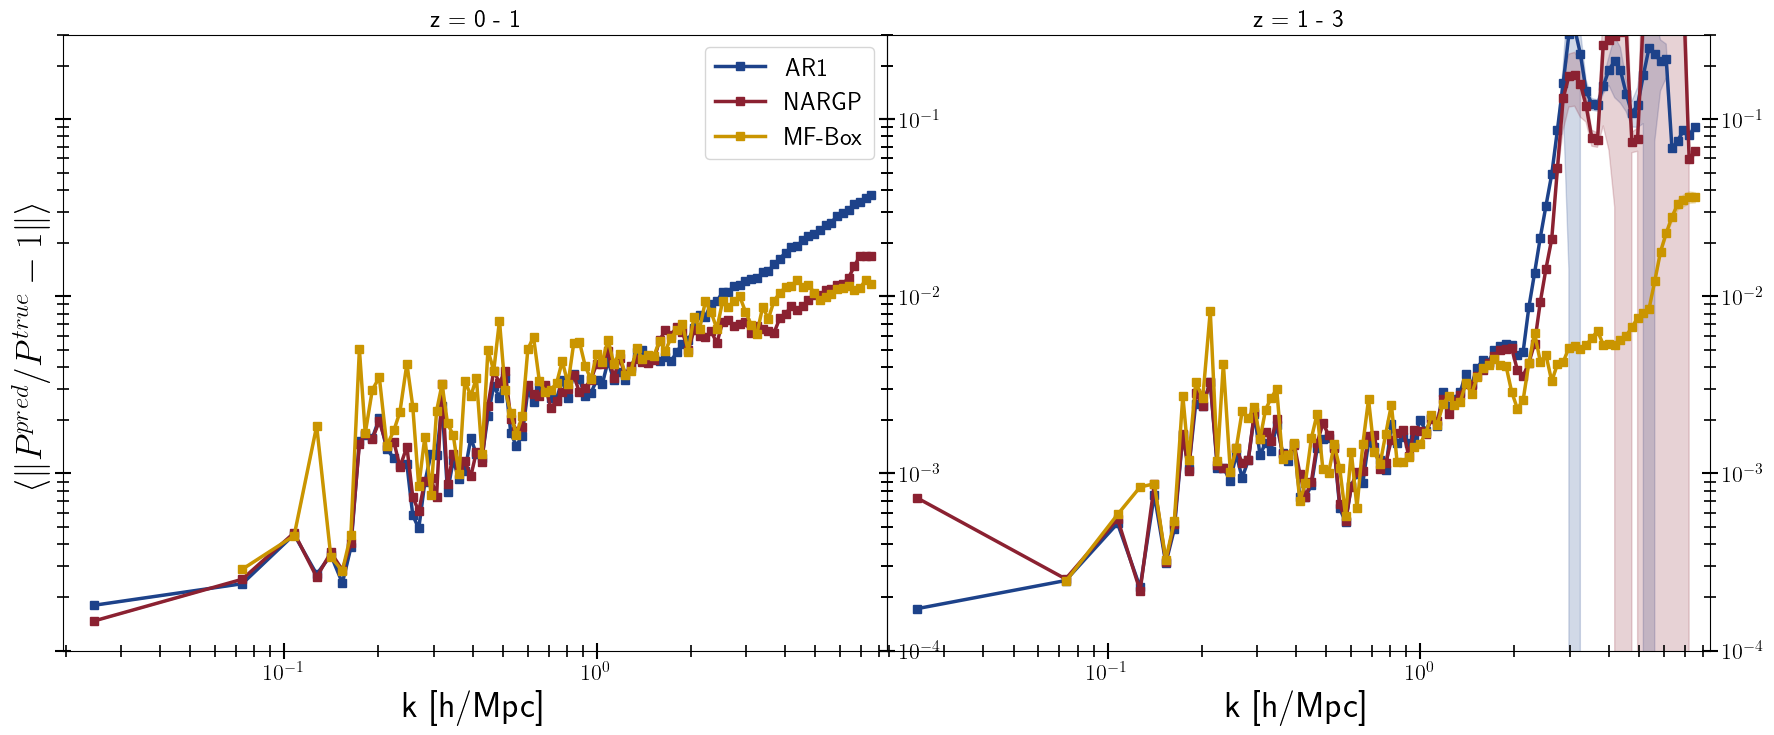

In [9]:
fig, axs = plt.subplots(figsize=(2*10.625, 8), nrows=1, ncols=2, sharey=True)

fig, ax = make_average_all_z_versus_k(
    vloaders.ar1_L60_H3_z0_1_2_slice_19,
    new_fig=False,
    color=colors[2],
    label="AR1",
    ax=axs[0],
    fig=fig,
    zmin=0.0,
    zmax=1.0,
)
fig, ax = make_average_all_z_versus_k(
    vloaders.nargp_L60_H3_z0_1_2_slice_19,
    new_fig=False,
    color=colors[0],
    label="NARGP",
    ax=ax,
    fig=fig,
    zmin=0.0,
    zmax=1.0,    
)

fig, ax = make_average_all_z_versus_k(
    vloaders.dgmgp_L60_H3_z0_1_2_slice_19,
    new_fig=False,
    color=colors[1],
    label=mf_box,
    ax=ax,
    fig=fig,
    zmin=0.0,
    zmax=1.0,
)

fig, ax = make_average_all_z_versus_k(
    vloaders.ar1_L60_H3_z0_1_2_slice_19,
    new_fig=False,
    color=colors[2],
    label="AR1",
    ax=axs[1],
    fig=fig,
    zmin=1.0,
    zmax=3.1,
)
fig, ax = make_average_all_z_versus_k(
    vloaders.nargp_L60_H3_z0_1_2_slice_19,
    new_fig=False,
    color=colors[0],
    label="NARGP",
    ax=ax,
    fig=fig,
    zmin=1.0,
    zmax=3.1,
)

fig, ax = make_average_all_z_versus_k(
    vloaders.dgmgp_L60_H3_z0_1_2_slice_19,
    new_fig=False,
    color=colors[1],
    label=mf_box,
    ax=ax,
    fig=fig,
    zmin=1.0,
    zmax=3.1,
)

# Martin style
axs[0].set_xlabel(r'k [h/Mpc]', fontsize=26)
axs[0].set_ylabel(r'$\langle\| P^{{pred}}/P^{{true}} - 1 \|\rangle$', fontsize=26)
axs[0].set_yscale('log')
axs[0].set_ylim([1e-4, 3e-1])
axs[0].set_xlim([kf_test.min()* 0.8, kf_test.max() * 1.1])

axs[1].set_xlabel(r'k [h/Mpc]', fontsize=26)
# axs[1].set_ylabel(r'$\langle\| P^{{pred}}/P^{{true}} - 1 \|\rangle$', fontsize=26)
axs[1].set_yscale('log')
axs[1].set_ylim([1e-4, 3e-1])
axs[1].set_xlim([kf_test.min()* 0.8, kf_test.max() * 1.1])

axs[0].tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)
axs[0].tick_params(which='minor', length=8)

axs[1].tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)
axs[1].tick_params(which='minor', length=8)

axs[0].legend()
axs[0].set_title("z = 0 - 1")
axs[1].set_title("z = 1 - 3")

axs[0].patch.set_facecolor('none')
axs[1].patch.set_facecolor('none')
fig.subplots_adjust(hspace=0, wspace=0)
fig.savefig(
    os.path.join("dgmgp_all_z_versus_k_split_scales.pdf"),
    bbox_inches='tight',
    pad_inches=0.075
)
plt.show()

### Break down the errors by redshift

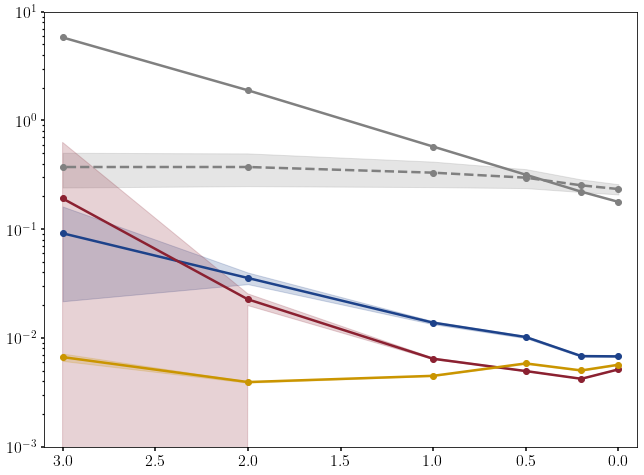

In [25]:
# z versus small and large scale error (all sims) for 40-4, LF and HF only
# L1 error exlcuded because variance is too large due to bias in the tail, which is not fair
fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1, sharey=True)
plt.setp(ax, ylim=[1e-3, 10], xlim=[3.1, -0.1], yscale='log')

zz = vloaders.ar1_L60_H3_z0_1_2_slice_19.z

k_pivot = 20 # h/Mpc

## Large scales
## Start here
## -------------
## 
# Shape (number of redshifts, number of test points, number of k bins)
kf = vloaders.ar1_L60_H3_z0_1_2_slice_19.kf[0]
ind = 10**kf < k_pivot
lfmean = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors_lf[:, :, ind].mean(axis=(1, 2))
lfstd  = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors_lf[:, :, ind].std(axis=(1, 2))

hfmean = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors_hf[:, :, ind].mean(axis=(1, 2))
hfstd  = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors_hf[:, :, ind].std(axis=(1, 2))

absmeanLF = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].mean(axis=(1, 2))
absstdLF  = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].std(axis=(1, 2))

absmeanNARGP = vloaders.nargp_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].mean(axis=(1, 2))
absstdNARGP  = vloaders.nargp_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].std(axis=(1, 2))

kf = vloaders.dgmgp_L60_H3_z0_1_2_slice_19.kf[0]
ind = 10**kf < k_pivot
absmeandGMGP = vloaders.dgmgp_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].mean(axis=(1, 2))
absstddGMGP  = vloaders.dgmgp_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].std(axis=(1, 2))

ax.plot(zz, lfmean, 'o-', c="grey", lw=2.5, label="60L1")
# ax[0].fill_between(zz, (lfmean-lfstd**2), (lfmean+lfstd**2), color=c_flatirons, alpha=0.4,)

ax.plot(zz, hfmean, 'o--', color="grey", lw=2.5, label="3H")
ax.fill_between(zz, (hfmean-hfstd**2), (hfmean+hfstd**2), color="grey", alpha=0.2)

ax.plot(zz, absmeanLF, 'o-', c=colors[2], lw=2.5, label="AR1: 60L1+3H")
ax.fill_between(zz, (absmeanLF-absstdLF**2), (absmeanLF+absstdLF**2), color=colors[2], alpha=0.2)

ax.plot(zz, absmeanNARGP, 'o-', c=colors[0], lw=2.5, label="NARGP: 60L1+3H")
ax.fill_between(zz, (absmeanNARGP-absstdNARGP**2), (absmeanNARGP+absstdNARGP**2), color=colors[0], alpha=0.2)

ax.plot(zz, absmeandGMGP, 'o-', c=colors[1], lw=2.5, label="dGMGP: 60L1+60L2+3H")
ax.fill_between(zz, (absmeandGMGP-absstddGMGP**2), (absmeandGMGP+absstddGMGP**2), color=colors[1], alpha=0.2)



### Break down the errors by redshift and scales

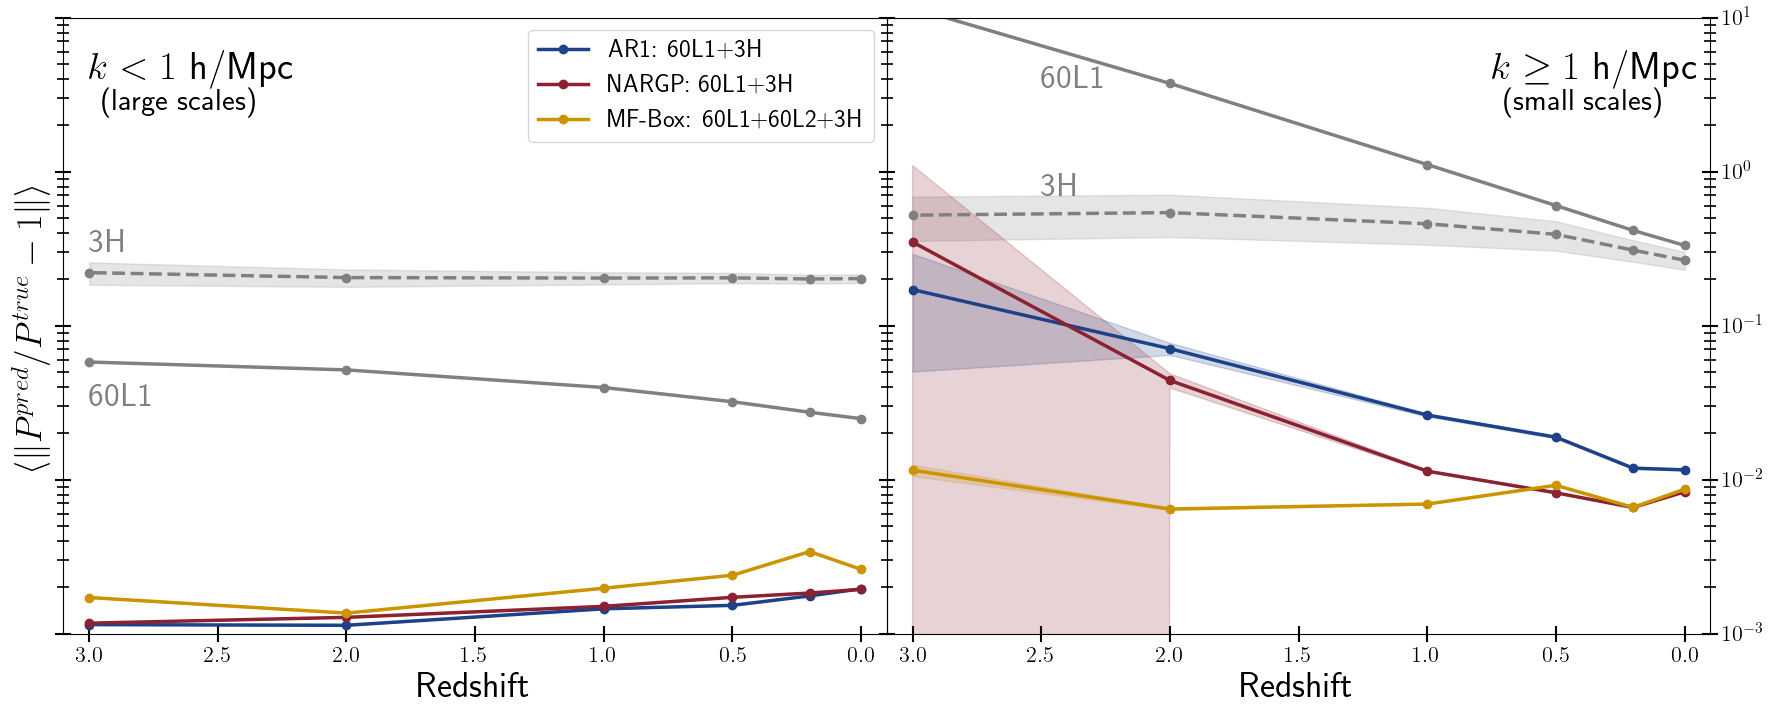

In [10]:
# z versus small and large scale error (all sims) for 40-4, LF and HF only
# L1 error exlcuded because variance is too large due to bias in the tail, which is not fair
fig, ax = plt.subplots(figsize=(2*10.625, 8), nrows=1, ncols=2, sharey=True)
plt.setp(ax, ylim=[1e-3, 10], xlim=[3.1, -0.1], yscale='log')

zz = vloaders.ar1_L60_H3_z0_1_2_slice_19.z

k_pivot = 1 # h/Mpc

## Large scales
## Start here
## -------------
## 
# Shape (number of redshifts, number of test points, number of k bins)
kf = vloaders.ar1_L60_H3_z0_1_2_slice_19.kf[0]
ind = 10**kf < k_pivot
lfmean = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors_lf[:, :, ind].mean(axis=(1, 2))
lfstd  = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors_lf[:, :, ind].std(axis=(1, 2))

hfmean = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors_hf[:, :, ind].mean(axis=(1, 2))
hfstd  = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors_hf[:, :, ind].std(axis=(1, 2))

absmeanLF = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].mean(axis=(1, 2))
absstdLF  = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].std(axis=(1, 2))

absmeanNARGP = vloaders.nargp_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].mean(axis=(1, 2))
absstdNARGP  = vloaders.nargp_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].std(axis=(1, 2))

kf = vloaders.dgmgp_L60_H3_z0_1_2_slice_19.kf[0]
ind = 10**kf < k_pivot
absmeandGMGP = vloaders.dgmgp_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].mean(axis=(1, 2))
absstddGMGP  = vloaders.dgmgp_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].std(axis=(1, 2))

ax[0].plot(zz, lfmean, 'o-', c="grey", lw=2.5, )
# ax[0].fill_between(zz, (lfmean-lfstd**2), (lfmean+lfstd**2), color=c_flatirons, alpha=0.4,)

ax[0].plot(zz, hfmean, 'o--', color="grey", lw=2.5, )
ax[0].fill_between(zz, (hfmean-hfstd**2), (hfmean+hfstd**2), color="grey", alpha=0.2)

ax[0].plot(zz, absmeanLF, 'o-', c=colors[2], lw=2.5, label="AR1: 60L1+3H")
ax[0].fill_between(zz, (absmeanLF-absstdLF**2), (absmeanLF+absstdLF**2), color=colors[2], alpha=0.2)

ax[0].plot(zz, absmeanNARGP, 'o-', c=colors[0], lw=2.5, label="NARGP: 60L1+3H")
ax[0].fill_between(zz, (absmeanNARGP-absstdNARGP**2), (absmeanNARGP+absstdNARGP**2), color=colors[0], alpha=0.2)

ax[0].plot(zz, absmeandGMGP, 'o-', c=colors[1], lw=2.5, label=mf_box + ": 60L1+60L2+3H")
ax[0].fill_between(zz, (absmeandGMGP-absstddGMGP**2), (absmeandGMGP+absstddGMGP**2), color=colors[1], alpha=0.2)


## Small scales
## Start here
## -------------
## 
# Shape (number of redshifts, number of test points, number of k bins)
kf = vloaders.ar1_L60_H3_z0_1_2_slice_19.kf[0]
ind = 10**kf >= k_pivot
lfmean = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors_lf[:, :, ind].mean(axis=(1, 2))
lfstd  = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors_lf[:, :, ind].std(axis=(1, 2))

hfmean = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors_hf[:, :, ind].mean(axis=(1, 2))
hfstd  = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors_hf[:, :, ind].std(axis=(1, 2))

absmeanLF = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].mean(axis=(1, 2))
absstdLF  = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].std(axis=(1, 2))

absmeanNARGP = vloaders.nargp_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].mean(axis=(1, 2))
absstdNARGP  = vloaders.nargp_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].std(axis=(1, 2))

kf = vloaders.dgmgp_L60_H3_z0_1_2_slice_19.kf[0]
ind = 10**kf >= k_pivot
absmeandGMGP = vloaders.dgmgp_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].mean(axis=(1, 2))
absstddGMGP  = vloaders.dgmgp_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].std(axis=(1, 2))

ax[1].plot(zz, lfmean, 'o-', c="grey", lw=2.5, label="60L1")
# ax[1].fill_between(zz, (lfmean-lfstd**2), (lfmean+lfstd**2), color=c_flatirons, alpha=0.4,)

ax[1].plot(zz, hfmean, 'o--', color="grey", lw=2.5, label="3H")
ax[1].fill_between(zz, (hfmean-hfstd**2), (hfmean+hfstd**2), color="grey", alpha=0.2)

ax[1].plot(zz, absmeanLF, 'o-', c=colors[2], lw=2.5, label="AR1: 60L1+3H")
ax[1].fill_between(zz, (absmeanLF-absstdLF**2), (absmeanLF+absstdLF**2), color=colors[2], alpha=0.2)

ax[1].plot(zz, absmeanNARGP, 'o-', c=colors[0], lw=2.5, label="NARGP: 60L1+3H")
ax[1].fill_between(zz, (absmeanNARGP-absstdNARGP**2), (absmeanNARGP+absstdNARGP**2), color=colors[0], alpha=0.2)

ax[1].plot(zz, absmeandGMGP, 'o-', c=colors[1], lw=2.5, label=mf_box + ": 60L1+60L2+3H")
ax[1].fill_between(zz, (absmeandGMGP-absstddGMGP**2), (absmeandGMGP+absstddGMGP**2), color=colors[1], alpha=0.2)

ax[0].text(3, 3e-2,   '60L1', c="grey", fontsize=24)
ax[0].text(3, 3e-1, '3H', color="grey", fontsize=24)
# ax[0].text(1, 0.7e-2, 'AR1: 60L1+3H', c=c_midnight, fontsize=24)
# ax[0].fill_between([4.1, 2.6], [3e-3, 3e-3], [3e-1, 3e-1], color=c_skyline, alpha=0.1)
# ax[0].text(3.98, 1.2e-1, r'He II Reionization', c=c_skyline, fontsize=24)
ax[0].text(3.0,  4, '$k < 1$ h/Mpc', color='k', fontsize=28)
ax[0].text(2.95, 2.5, '(large scales)', color='k', fontsize=22)

ax[1].text(2.5, 3.5,   '60L1', c="grey", fontsize=24)
ax[1].text(2.5, 7e-1, '3H', color="grey", fontsize=24)
# ax[1].text(3.2, 0.6e-2, '40 LF + 6 HF', c=c_midnight, fontsize=24)
# ax[1].fill_between([4.1, 2.6], [3e-3, 3e-3], [3e-1, 3e-1], color=c_skyline, alpha=0.1)
# ax[1].text(3.98, 1.2e-1, r'He II Reionization', c=c_skyline, fontsize=24)
ax[1].text(0.75, 4, '$k \geq 1$ h/Mpc', color='k', fontsize=28)
ax[1].text(0.70, 2.5, '(small scales)', color='k', fontsize=22)

ax[0].set_xlabel(r'Redshift', fontsize=26)
ax[1].set_xlabel(r'Redshift', fontsize=26)
ax[0].set_ylabel(r'$\langle\| P^{{pred}}/P^{{true}} - 1 \|\rangle$', fontsize=26)

ax[0].tick_params(which='both', direction='inout', labelleft=False, length=12)
ax[0].tick_params(which='minor', length=8)
ax[1].tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)
ax[1].tick_params(which='minor', length=8)

ax[0].patch.set_facecolor('none')
ax[1].patch.set_facecolor('none')

ax[0].legend()

fig.subplots_adjust(hspace=0, wspace=0)
fig.savefig(
    os.path.join("dgmgp_all_k_versus_z_and_scales.pdf"),
    bbox_inches='tight', pad_inches=0.075
)
plt.show()

### Compare errors to non-linear GP

### Total computation time and error

In [12]:
# Get the error including redshifts, [0, 0.2, 0.5, 1, 2]
# LF only
emu_list = [
    vloaders.ar1_H3_slice19,
    vloaders.ar1_H3_slice19_z0_2,
    vloaders.ar1_H3_slice19_z0_5,
    vloaders.ar1_H3_slice19_z1,
    vloaders.ar1_H3_slice19_z2,
    vloaders.ar1_H3_slice19_z3,
]
# shape (redshifts, vary lf, test sims, k bins)
lf_only_error = np.array([
    emu.relative_errors_lf for emu in emu_list 
])


# HF only
emu_list = [
    vloaders.ar1_L60_H3_10_z0,
    vloaders.ar1_L60_H3_10_z0_2,
    vloaders.ar1_L60_H3_10_z0_5,
    vloaders.ar1_L60_H3_10_z1,
    vloaders.ar1_L60_H3_10_z2,
    vloaders.ar1_L60_H3_10_z3,
]
# shape (redshifts, vary hf, test sims, k bins)
hf_only_error = np.array([
    emu.relative_errors_hf for emu in emu_list 
])


# MF: [Vary LF]-3H
ar1_list = [
    vloaders.ar1_H3_slice19,
    vloaders.ar1_H3_slice19_z0_2,
    vloaders.ar1_H3_slice19_z0_5,
    vloaders.ar1_H3_slice19_z1,
    vloaders.ar1_H3_slice19_z2,
    vloaders.ar1_H3_slice19_z3,
]
nargp_list = [
    vloaders.nargp_H3_slice19,
    vloaders.nargp_H3_slice19_z0_2,
    vloaders.nargp_H3_slice19_z0_5,
    vloaders.nargp_H3_slice19_z1,
    vloaders.nargp_H3_slice19_z2,
    vloaders.nargp_H3_slice19_z3,
]
dgmgp_list = [
    vloaders.dgmgp_H3_slice19,
    vloaders.dgmgp_H3_slice19_z0_2,
    vloaders.dgmgp_H3_slice19_z0_5,
    vloaders.dgmgp_H3_slice19_z1,
    vloaders.dgmgp_H3_slice19_z2,
    vloaders.dgmgp_H3_slice19_z3,
]
# shape (redshifts, vary lf, test sims, k bins)
ar1_vary_lf = np.array([
    emu.relative_errors for emu in ar1_list
])
nargp_vary_lf = np.array([
    emu.relative_errors for emu in nargp_list
])
dgmgp_vary_lf = np.array([
    emu.relative_errors for emu in dgmgp_list
])

# LF2 errors:
# shape (redshifts, vary lf, test sims, k bins)
lf_only_error_2 = np.array([
    np.abs(emu._pred_exacts_lf_2 - 1) for emu in dgmgp_list
])


# MF: 60L-[Vary H]
ar1_list = [
    vloaders.ar1_L60_H3_10_z0,
    vloaders.ar1_L60_H3_10_z0_2,
    vloaders.ar1_L60_H3_10_z0_5,
    vloaders.ar1_L60_H3_10_z1,
    vloaders.ar1_L60_H3_10_z2,
    vloaders.ar1_L60_H3_10_z3,
]
nargp_list = [
    vloaders.nargp_L60_H3_10_z0,
    vloaders.nargp_L60_H3_10_z0_2,
    vloaders.nargp_L60_H3_10_z0_5,
    vloaders.nargp_L60_H3_10_z1,
    vloaders.nargp_L60_H3_10_z2,
    vloaders.nargp_L60_H3_10_z3,
]
dgmgp_list = [
    vloaders.dgmgp_L60_H3_10_z0,
    vloaders.dgmgp_L60_H3_10_z0_2,
    vloaders.dgmgp_L60_H3_10_z0_5,
    vloaders.dgmgp_L60_H3_10_z1,
    vloaders.dgmgp_L60_H3_10_z2,
    vloaders.dgmgp_L60_H3_10_z3,
]
# shape (redshifts, vary hf, test sims, k bins)
ar1_vary_hf = np.array([
    emu.relative_errors for emu in ar1_list
])
nargp_vary_hf = np.array([
    emu.relative_errors for emu in nargp_list
])
dgmgp_vary_hf = np.array([
    emu.relative_errors for emu in dgmgp_list
])




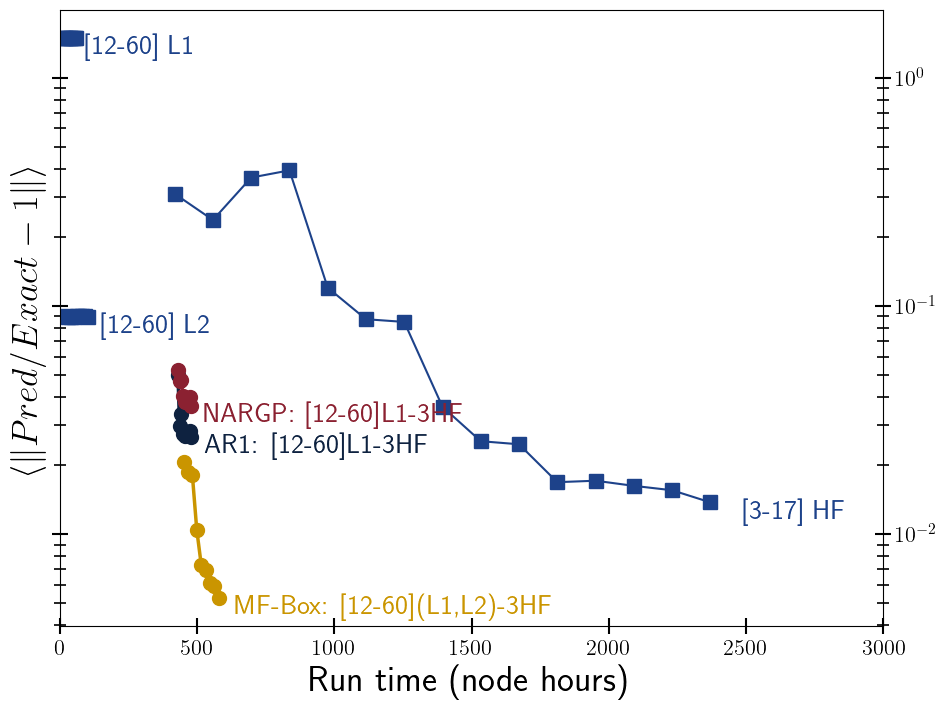

In [13]:
# # optimization times converted to hours -- too subdominant to matter
# times_4hf = np.array([84, 85, 92, 106, 133, 166, 156, 160, 173, 180, 174, 179, 179, 194, 197, 194, 193, 195, 187])/60
# times_3hf = np.array([118, 174, 172, 192])/60
# times_2hf = np.array([92, 178, 193, 202])/60

# LF1: used 8 nodes, MPIs: 16 Threads: 32 Elapsed: 446.128 
# [TODO] Currently only a rough estimate
time_per_lfsim = np.mean([446.128, 402.408, 518.769, 436.079]) * 8 / 3600
time_per_hfsim = np.mean([47452.16, 58640.92, 82104.07])       * 8 / 3600

time_per_lfsim2 = np.mean([638.619, 767.55, 953.475, 724.265, 706.971]) * 8 / 3600

fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

# LF only
ax.plot(
    np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim,
    lf_only_error.mean(axis=(0, 2, 3)),
    's-',
    c=c_skyline,
    ms=10
)
ax.plot(
    np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim2,
    lf_only_error_2.mean(axis=(0, 2, 3)),
    's-',
    c=c_skyline,
    ms=10
)

# HF only
ax.plot(
    np.array([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]) * time_per_hfsim,
    hf_only_error.mean(axis=(0, 2, 3)),
    's-',
    c=c_skyline,
    ms=10
)
# MF: Vary LF
ax.plot(
    np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim +
    3 * time_per_hfsim,
    ar1_vary_lf.mean(axis=(0, 2, 3)),
    'o-',
    lw=2.5,
    c=c_midnight,
    ms=10,
    label="AR1 [12-60]L1-3H",
)
ax.plot(
    np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim +
    3 * time_per_hfsim,
    nargp_vary_lf.mean(axis=(0, 2, 3)),
    'o-',
    lw=2.5,
    c=c_flatirons,
    ms=10,
    label="NARGP [12-60]L1-3H",
)
ax.plot(
    np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim +
    np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim2 +
    3 * time_per_hfsim,
    dgmgp_vary_lf.mean(axis=(0, 2, 3)),
    'o-',
    lw=2.5,
    c=c_sunshine,
    ms=10,
    label=mf_box + " [12-60]L1-[12-60]L2-3H",
)

# Texts
ax.text(
    1.5 * 60 * time_per_lfsim,
    0.85*lf_only_error.mean(axis=(0, 2, 3))[-1],
    '[12-60] L1',
    fontsize=20,
    color=c_skyline,
)
ax.text(
    1.5 * 60 * time_per_lfsim2,
    0.85*lf_only_error_2.mean(axis=(0, 2, 3))[-1],
    '[12-60] L2',
    fontsize=20,
    color=c_skyline,
)
ax.text(
    1.05 * 17 * time_per_hfsim,
    0.85*hf_only_error.mean(axis=(0, 2, 3))[-1],
    '[3-17] HF',
    fontsize=20,
    color=c_skyline,
)
ax.text(
    1.1 * (3 * time_per_hfsim + 60 * time_per_lfsim),
    0.85*ar1_vary_lf.mean(axis=(0, 2, 3))[-1],
    'AR1: [12-60]L1-3HF',
    fontsize=20,
    color=c_midnight,
)
ax.text(
    1.1 * (3 * time_per_hfsim + 60 * time_per_lfsim),
    0.85*nargp_vary_lf.mean(axis=(0, 2, 3))[-1],
    'NARGP: [12-60]L1-3HF',
    fontsize=20,
    color=c_flatirons,
)
ax.text(
    1.1 * (3 * time_per_hfsim + 60 * time_per_lfsim + 60 * time_per_lfsim2),
    0.85*dgmgp_vary_lf.mean(axis=(0, 2, 3))[-1],
    mf_box + ': [12-60](L1,L2)-3HF',
    fontsize=20,
    color=c_sunshine,
)

ax.set_xlabel('Run time (node hours)', fontsize=26)
ax.set_ylabel(r'$\langle\| Pred/Exact - 1 \|\rangle$', fontsize=26)
ax.set_yscale('log')
# ax.set_xscale('log')

# ax.set_ylim([7e-3, 1e-1])
ax.set_xlim([0, 3000])

ax.tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)
ax.tick_params(which='minor', length=8, labelright=False, labelleft=False)

fig.patch.set_facecolor('none')
fig.subplots_adjust(hspace=0, wspace=0)
fig.savefig(
    os.path.join(imgdir, "runtime_error.pdf"),
    bbox_inches='tight', pad_inches=0.075
)
plt.show()

In [33]:
# conservative estimate of the HF emulation error to match MFBOX
hf_costs = np.array([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]) * time_per_hfsim
n_hf = np.array([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])

x = hf_costs[-5:]
y = hf_only_error.mean(axis=(0, 2, 3))[-5:]

# MFBOX best error
best_mfbox = dgmgp_vary_lf.mean(axis=(0, 2, 3))[-1]

# save to txt
np.savetxt("budget_size/hfonly_budget_size.txt",
            [n_hf, hf_only_error.mean(axis=(0, 2, 3)), hf_only_error.std(axis=(0, 2, 3))]
          )

y, best_mfbox

slope = (y[-1] - y[0]) / (x[-1] - x[0])

# problem: best_mfbox = slope * cost + y[-1]
#          (best_mfbox - y[-1]) / slope = cost
(best_mfbox - y[-1]) / slope

1525.4969629522545

Zoom in version of MF Emulators


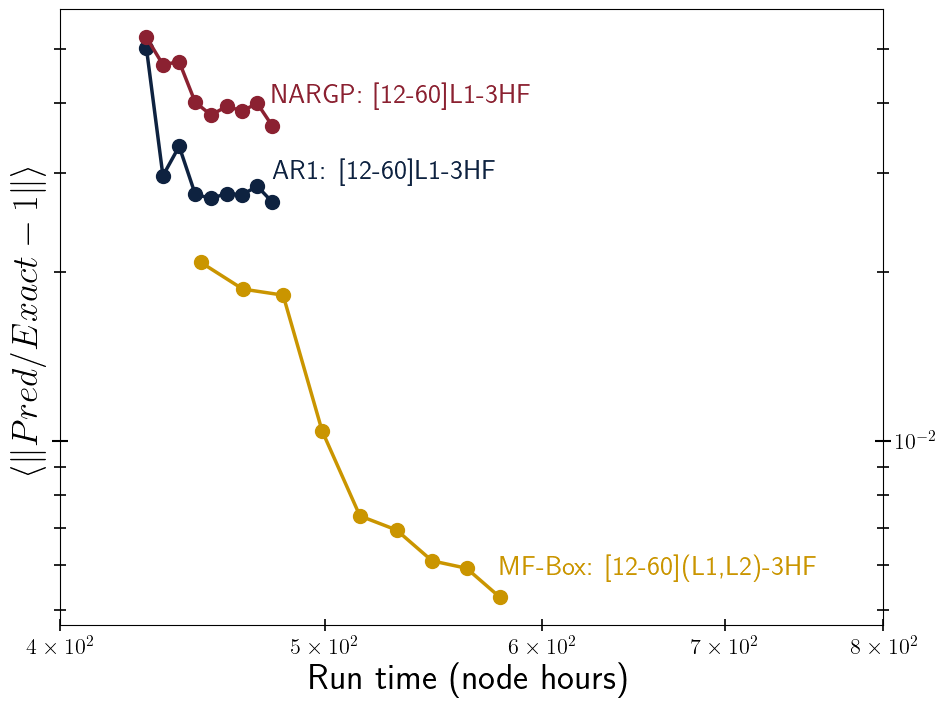

In [13]:
# # optimization times converted to hours -- too subdominant to matter
# times_4hf = np.array([84, 85, 92, 106, 133, 166, 156, 160, 173, 180, 174, 179, 179, 194, 197, 194, 193, 195, 187])/60
# times_3hf = np.array([118, 174, 172, 192])/60
# times_2hf = np.array([92, 178, 193, 202])/60

# LF1: used 8 nodes, MPIs: 16 Threads: 32 Elapsed: 446.128 
# [TODO] Currently only a rough estimate
time_per_lfsim = np.mean([446.128, 402.408, 518.769, 436.079]) * 8 / 3600
time_per_hfsim = np.mean([47452.16, 58640.92, 82104.07])       * 8 / 3600

time_per_lfsim2 = np.mean([638.619, 767.55, 953.475, 724.265, 706.971]) * 8 / 3600

fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)


# MF: Vary LF
ax.plot(
    np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim +
    3 * time_per_hfsim,
    ar1_vary_lf.mean(axis=(0, 2, 3)),
    'o-',
    lw=2.5,
    c=c_midnight,
    ms=10,
    label="AR1 [12-60]L1-3H",
)
ax.plot(
    np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim +
    3 * time_per_hfsim,
    nargp_vary_lf.mean(axis=(0, 2, 3)),
    'o-',
    lw=2.5,
    c=c_flatirons,
    ms=10,
    label="NARGP [12-60]L1-3H",
)
ax.plot(
    np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim +
    np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim2 +
    3 * time_per_hfsim,
    dgmgp_vary_lf.mean(axis=(0, 2, 3)),
    'o-',
    lw=2.5,
    c=c_sunshine,
    ms=10,
    label="dGMGP [12-60]L1-[12-60]L2-3H",
)

ax.text(
    1 * (3 * time_per_hfsim + 60 * time_per_lfsim),
    1.1*ar1_vary_lf.mean(axis=(0, 2, 3))[-1],
    'AR1: [12-60]L1-3HF',
    fontsize=20,
    color=c_midnight,
)
ax.text(
    1 * (3 * time_per_hfsim + 60 * time_per_lfsim),
    1.1*nargp_vary_lf.mean(axis=(0, 2, 3))[-1],
    'NARGP: [12-60]L1-3HF',
    fontsize=20,
    color=c_flatirons,
)
ax.text(
    1 * (3 * time_per_hfsim + 60 * time_per_lfsim + 60 * time_per_lfsim2),
    1.1*dgmgp_vary_lf.mean(axis=(0, 2, 3))[-1],
    mf_box + ': [12-60](L1,L2)-3HF',
    fontsize=20,
    color=c_sunshine,
)

ax.set_xlabel('Run time (node hours)', fontsize=26)
ax.set_ylabel(r'$\langle\| Pred/Exact - 1 \|\rangle$', fontsize=26)
ax.set_yscale('log')
ax.set_xscale('log')

# ax.set_ylim([7e-3, 1e-1])
ax.set_xlim([400, 800])

ax.tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)
ax.tick_params(which='minor', length=8, labelright=False, labelleft=False)

fig.patch.set_facecolor('none')
fig.subplots_adjust(hspace=0, wspace=0)
fig.savefig(
    os.path.join(imgdir, "runtime_error_zoom_in.pdf"),
    bbox_inches='tight', pad_inches=0.075
)
plt.show()

## Proposal plot

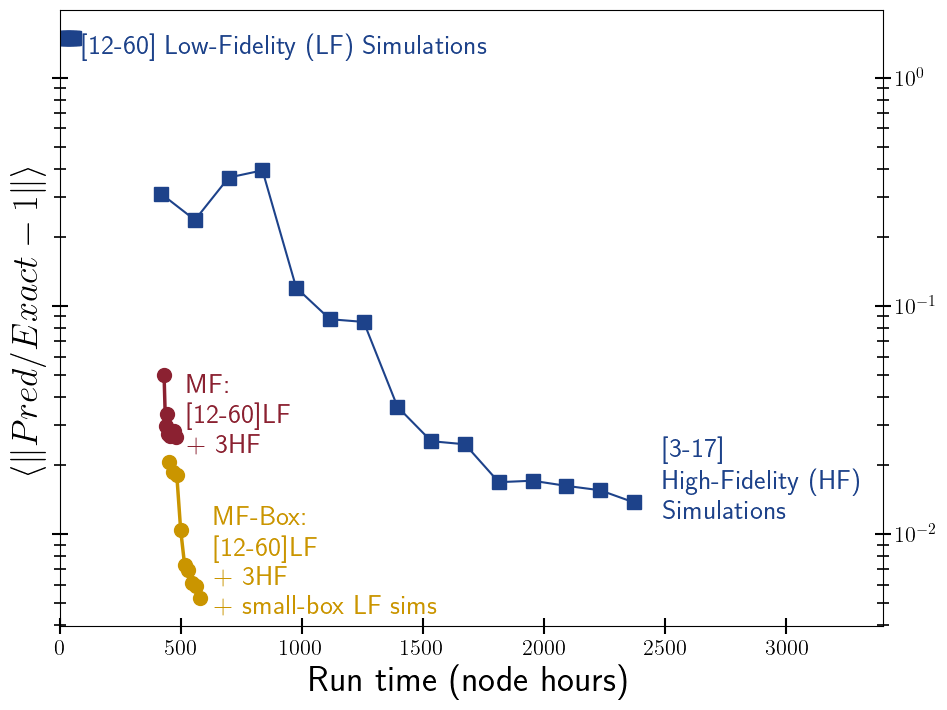

In [30]:
# # optimization times converted to hours -- too subdominant to matter
# times_4hf = np.array([84, 85, 92, 106, 133, 166, 156, 160, 173, 180, 174, 179, 179, 194, 197, 194, 193, 195, 187])/60
# times_3hf = np.array([118, 174, 172, 192])/60
# times_2hf = np.array([92, 178, 193, 202])/60

# LF1: used 8 nodes, MPIs: 16 Threads: 32 Elapsed: 446.128 
# [TODO] Currently only a rough estimate
time_per_lfsim = np.mean([446.128, 402.408, 518.769, 436.079]) * 8 / 3600
time_per_hfsim = np.mean([47452.16, 58640.92, 82104.07])       * 8 / 3600

time_per_lfsim2 = np.mean([638.619, 767.55, 953.475, 724.265, 706.971]) * 8 / 3600

fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

# LF only
ax.plot(
    np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim,
    lf_only_error.mean(axis=(0, 2, 3)),
    's-',
    c=c_skyline,
    ms=10
)
# ax.plot(
#     np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim2,
#     lf_only_error_2.mean(axis=(0, 2, 3)),
#     's-',
#     c=c_skyline,
#     ms=10
# )

# HF only
ax.plot(
    np.array([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]) * time_per_hfsim,
    hf_only_error.mean(axis=(0, 2, 3)),
    's-',
    c=c_skyline,
    ms=10
)
# MF: Vary LF
ax.plot(
    np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim +
    3 * time_per_hfsim,
    ar1_vary_lf.mean(axis=(0, 2, 3)),
    'o-',
    lw=2.5,
    c=c_flatirons,
    ms=10,
    label="AR1 [12-60]L1-3H",
)
# ax.plot(
#     np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim +
#     3 * time_per_hfsim,
#     nargp_vary_lf.mean(axis=(0, 2, 3)),
#     'o-',
#     lw=2.5,
#     c=c_flatirons,
#     ms=10,
#     label="NARGP [12-60]L1-3H",
# )
ax.plot(
    np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim +
    np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim2 +
    3 * time_per_hfsim,
    dgmgp_vary_lf.mean(axis=(0, 2, 3)),
    'o-',
    lw=2.5,
    c=c_sunshine,
    ms=10,
    label=mf_box + " [12-60]L1-[12-60]L2-3H",
)

# Texts
ax.text(
    1.5 * 60 * time_per_lfsim,
    0.85*lf_only_error.mean(axis=(0, 2, 3))[-1],
    '[12-60] Low-Fidelity (LF) Simulations',
    fontsize=20,
    color=c_skyline,
)
# ax.text(
#     1.5 * 60 * time_per_lfsim2,
#     0.85*lf_only_error_2.mean(axis=(0, 2, 3))[-1],
#     '[12-60] L2',
#     fontsize=20,
#     color=c_skyline,
# )
ax.text(
    1.05 * 17 * time_per_hfsim,
    0.85*hf_only_error.mean(axis=(0, 2, 3))[-1],
    '[3-17] \nHigh-Fidelity (HF) \nSimulations',
    fontsize=20,
    color=c_skyline,
)
ax.text(
    1.1 * (3 * time_per_hfsim + 60 * time_per_lfsim),
    0.85*ar1_vary_lf.mean(axis=(0, 2, 3))[-1],
    'MF: \n[12-60]LF \n+ 3HF',
    fontsize=20,
    color=c_flatirons,
)
# ax.text(
#     1.1 * (3 * time_per_hfsim + 60 * time_per_lfsim),
#     0.85*nargp_vary_lf.mean(axis=(0, 2, 3))[-1],
#     'NARGP: [12-60]L1-3HF',
#     fontsize=20,
#     color=c_flatirons,
# )
ax.text(
    1.1 * (3 * time_per_hfsim + 60 * time_per_lfsim + 60 * time_per_lfsim2),
    0.85*dgmgp_vary_lf.mean(axis=(0, 2, 3))[-1],
    mf_box + ': \n[12-60]LF\n+ 3HF\n+ small-box LF sims',
    fontsize=20,
    color=c_sunshine,
)

ax.set_xlabel('Run time (node hours)', fontsize=26)
ax.set_ylabel(r'$\langle\| Pred/Exact - 1 \|\rangle$', fontsize=26)
ax.set_yscale('log')
# ax.set_xscale('log')

# ax.set_ylim([7e-3, 1e-1])
ax.set_xlim([0, 3400])

ax.tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)
ax.tick_params(which='minor', length=8, labelright=False, labelleft=False)

fig.patch.set_facecolor('none')
fig.subplots_adjust(hspace=0, wspace=0)
fig.savefig(
    os.path.join("../../Latex/postdoc_app_2022/images/", "runtime_error.pdf"),
    bbox_inches='tight', pad_inches=0.075
)
plt.show()

### Break Down into number of HF or LF

##### 1) Number of LF

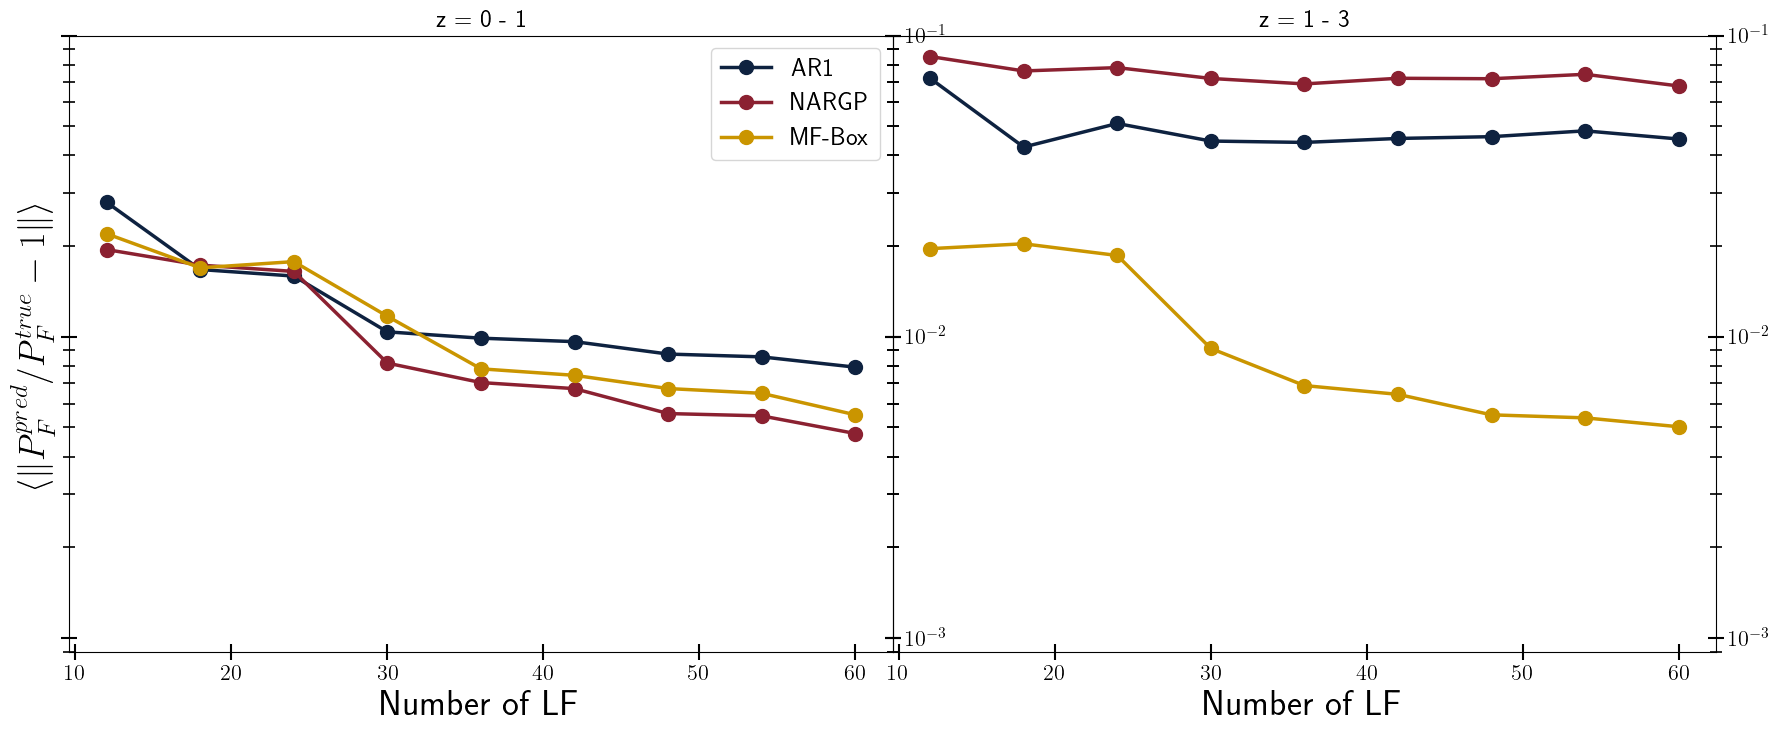

In [14]:
fig, axs = plt.subplots(figsize=(2*10.625, 8), nrows=1, ncols=2, sharey=True)

number_lf = vloaders.ar1_H3_slice19.num_lf

# zz = np.array([0, 0.2, 0.5, 1, 2, 3])

# num_hf versus error
# shape (redshifts, vary lf, test sims, k bins)
axs[0].plot(
    number_lf,
    ar1_vary_lf[:3, :, : ,:].mean(axis=(0, 2, 3)),
    'o-',
    lw=2.5,
    ms=10,
    color=c_midnight,
    label="AR1",
)
axs[0].plot(
    number_lf,
    nargp_vary_lf[:3, :, : ,:].mean(axis=(0, 2, 3)),
    'o-',
    lw=2.5,    
    ms=10,    
    color=c_flatirons,
    label="NARGP"
)
axs[0].plot(
    number_lf,
    dgmgp_vary_lf[:3, :, : ,:].mean(axis=(0, 2, 3)),
    'o-',
    lw=2.5,
    ms=10,    
    color=c_sunshine,
    label=mf_box
)

axs[1].plot(
    number_lf,
    ar1_vary_lf[3:, :, : ,:].mean(axis=(0, 2, 3)),
    'o-',
    lw=2.5,
    ms=10,    
    color=c_midnight,
)
axs[1].plot(
    number_lf,
    nargp_vary_lf[3:, :, : ,:].mean(axis=(0, 2, 3)),
    'o-',
    lw=2.5,    
    ms=10,    
    color=c_flatirons,
)
axs[1].plot(
    number_lf,
    dgmgp_vary_lf[3:, :, : ,:].mean(axis=(0, 2, 3)),
    'o-',
    lw=2.5,
    ms=10,    
    color=c_sunshine,
)


axs[0].set_xlabel('Number of LF', fontsize=26)
axs[0].set_ylabel(r'$\langle\| P_F^{{pred}}/P_F^{{true}} - 1 \|\rangle$', fontsize=26)
axs[0].set_yscale('log')
axs[0].set_ylim([3e-4, 1e-1])

axs[1].set_xlabel('Number of LF', fontsize=26)
# axs[1].set_ylabel(r'$\langle\| P_F^{{pred}}/P_F^{{true}} - 1 \|\rangle$', fontsize=26)
axs[1].set_yscale('log')
axs[1].set_ylim([9e-4, 1e-1])

axs[0].tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)
axs[0].tick_params(which='minor', length=8)

axs[1].tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)
axs[1].tick_params(which='minor', length=8)

axs[0].legend()
axs[0].set_title("z = 0 - 1")
axs[1].set_title("z = 1 - 3")

axs[0].patch.set_facecolor('none')
axs[1].patch.set_facecolor('none')
fig.subplots_adjust(hspace=0, wspace=0)
fig.savefig(os.path.join(imgdir, "vary_lf.pdf"), bbox_inches='tight', pad_inches=0.075)
plt.show()

In [37]:
time_per_lfsim2

1.6848355555555554

In [36]:
time_per_lfsim

1.00188

In [35]:
time_per_hfsim

139.4052962962963

In [40]:
512**3 * np.log(512 ** 3) / (128**3 * np.log(128**3))

82.28571428571429

##### 2) Number of HF

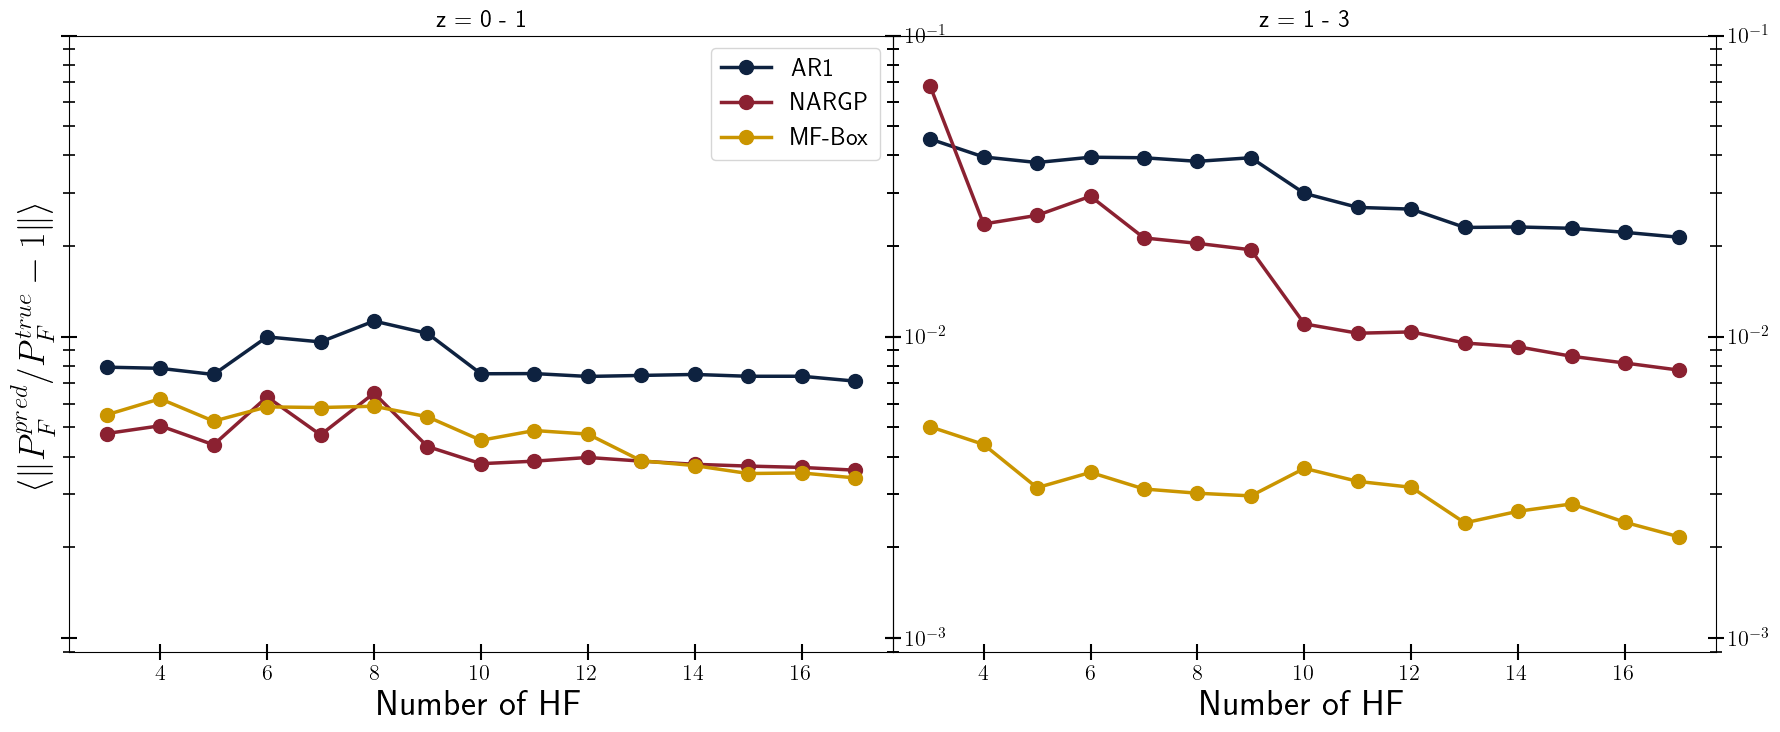

In [15]:
fig, axs = plt.subplots(figsize=(2*10.625, 8), nrows=1, ncols=2, sharey=True)

number_hf = vloaders.dgmgp_L60_H3_10_z0.num_hf

# zz = np.array([0, 0.2, 0.5, 1, 2, 3])

# num_hf versus error
# shape (redshifts, vary lf, test sims, k bins)
axs[0].plot(
    number_hf,
    ar1_vary_hf[:3, :, : ,:].mean(axis=(0, 2, 3)),
    'o-',
    lw=2.5,
    ms=10,
    color=c_midnight,
    label="AR1",
)
axs[0].plot(
    number_hf,
    nargp_vary_hf[:3, :, : ,:].mean(axis=(0, 2, 3)),
    'o-',
    lw=2.5,    
    ms=10,    
    color=c_flatirons,
    label="NARGP"
)
axs[0].plot(
    number_hf,
    dgmgp_vary_hf[:3, :, : ,:].mean(axis=(0, 2, 3)),
    'o-',
    lw=2.5,
    ms=10,    
    color=c_sunshine,
    label=mf_box
)

axs[1].plot(
    number_hf,
    ar1_vary_hf[3:, :, : ,:].mean(axis=(0, 2, 3)),
    'o-',
    lw=2.5,
    ms=10,    
    color=c_midnight,
)
axs[1].plot(
    number_hf,
    nargp_vary_hf[3:, :, : ,:].mean(axis=(0, 2, 3)),
    'o-',
    lw=2.5,    
    ms=10,    
    color=c_flatirons,
)
axs[1].plot(
    number_hf,
    dgmgp_vary_hf[3:, :, : ,:].mean(axis=(0, 2, 3)),
    'o-',
    lw=2.5,
    ms=10,    
    color=c_sunshine,
)


axs[0].set_xlabel('Number of HF', fontsize=26)
axs[0].set_ylabel(r'$\langle\| P_F^{{pred}}/P_F^{{true}} - 1 \|\rangle$', fontsize=26)
axs[0].set_yscale('log')
axs[0].set_ylim([3e-4, 1e-1])

axs[1].set_xlabel('Number of HF', fontsize=26)
# axs[1].set_ylabel(r'$\langle\| P_F^{{pred}}/P_F^{{true}} - 1 \|\rangle$', fontsize=26)
axs[1].set_yscale('log')
axs[1].set_ylim([9e-4, 1e-1])

axs[0].tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)
axs[0].tick_params(which='minor', length=8)

axs[1].tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)
axs[1].tick_params(which='minor', length=8)

axs[0].legend()
axs[0].set_title("z = 0 - 1")
axs[1].set_title("z = 1 - 3")

axs[0].patch.set_facecolor('none')
axs[1].patch.set_facecolor('none')
fig.subplots_adjust(hspace=0, wspace=0)
fig.savefig(os.path.join(imgdir, "vary_hf.pdf"), bbox_inches='tight', pad_inches=0.075)
plt.show()

### Plot showing the parameter samples

In [16]:
def plot_samples(lores_h5: str, hires_h5: str, savefile=None, num_hires: int = 3):
    # get samples
    with h5py.File(lores_h5, "r") as f:
        lores = f["params"][()]
        # get parameter limits
        plimits = f["bounds"][()]
    with h5py.File(hires_h5, "r") as f:
        hires = f["params"][()]

        hires_slice_57_58_59 = hires[-num_hires:]
        hires_slice_0_1_2 = hires[:num_hires]

    nsim, npar = np.shape(lores)

    # parameter names - better formatting than from the json file
    names = [
        r"$\Omega_0$",
        r"$\Omega_b$",
        r"$h$",
        r"$A_s$",
        r"$n_s$",
    ]

    # make the plot
    yy = np.ones(nsim)
    fig, ax = plt.subplots(figsize=(10.625, 8), nrows=npar, ncols=1)
    for i in range(npar):
        ax[i].set_yticks([i])
        ax[i].set_yticklabels([names[i]], fontsize=26)
        ax[i].plot(lores[:, i], i*yy, 'x', color=c_midnight, ms=15, mew=2.5, alpha=0.66, label="LF")
        ax[i].plot(
            hires_slice_57_58_59[:, i], i*np.ones(np.shape(hires_slice_57_58_59)[0]), 'o', color=c_flatirons, ms=15, mew=3, mfc='none',
            label="HF: slice 0"
        )

        # second slice
        ax[i].plot(
            hires_slice_0_1_2[:, i], i*np.ones(np.shape(hires_slice_0_1_2)[0]), 'o', color=colors[1], ms=15, mew=3, mfc='none',
            label="HF: slice 1"
        )

        if i == 1:
            ax[i].legend(bbox_to_anchor=(0.25, 0.8), ncol=3)

        ax[i].set_xlim(plimits[i])
        ax[i].set_xticks(plimits[i])
        ax[i].set_xticklabels(["{:.2g}".format(p) for p in plimits[i]])

        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['left'].set_visible(False)
        ax[i].yaxis.set_ticks_position('left')
        ax[i].xaxis.set_ticks_position('bottom')    
        ax[i].patch.set_facecolor('none')

    fig.subplots_adjust(hspace=2, wspace=0)
    
    return fig

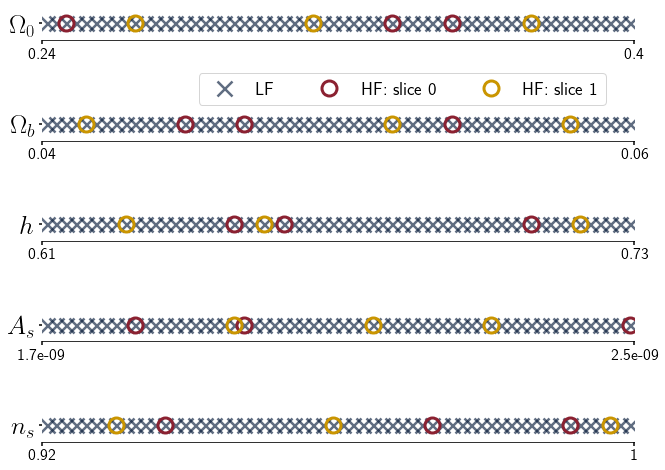

In [76]:
# current emulator setup
fig = plot_samples("data/dmo_60_res128box256/cc_emulator_powerspecs.hdf5", "data/dmo_24_res512box256/cc_emulator_powerspecs.hdf5")
fig.savefig(
    "/home/jibancat/Documents/Latex/mf_boxsize_paper/images/LHS_samples.pdf",
    bbox_inches='tight', pad_inches=0.075
)
plt.show()

## Boxsize difference

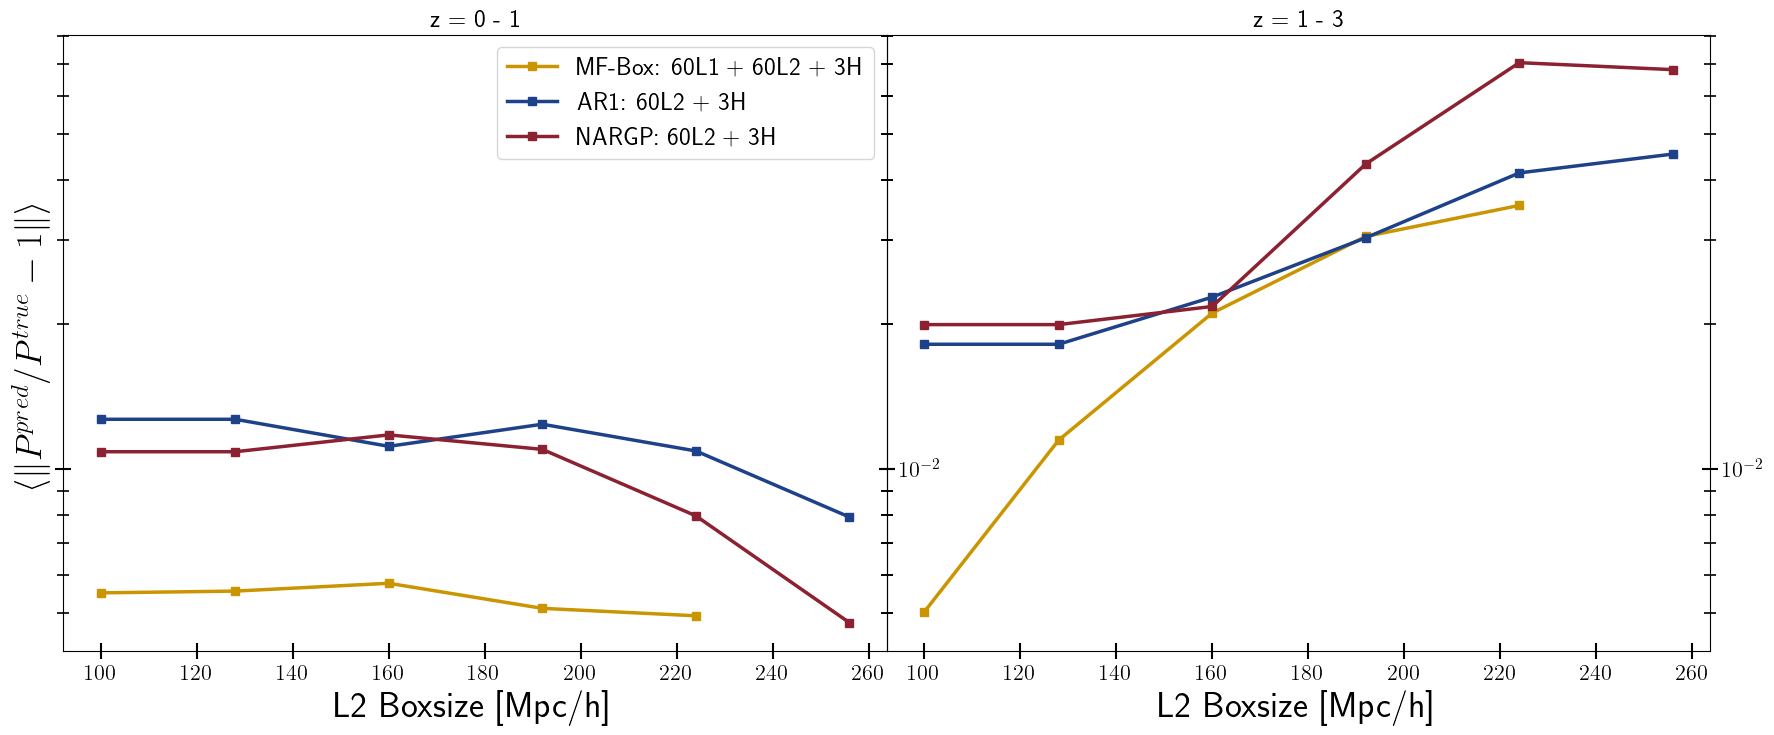

In [17]:
boxsizes = [100, 128, 160, 192, 224, ]

list_emu = [
    vloaders.dgmgp_L60_H3_z0_1_2_slice_19.relative_errors,
    vloaders.dgmgp_L60_L2box128_H3_z0_1_2_slice_19.relative_errors,
    vloaders.dgmgp_L60_L2box160_H3_z0_1_2_slice_19.relative_errors,
    vloaders.dgmgp_L60_L2box192_H3_z0_1_2_slice_19.relative_errors,
    vloaders.dgmgp_L60_L2box224_H3_z0_1_2_slice_19.relative_errors,
]

# control: NARGP with 256 Mpc/h
list_ar1 = [
    vloaders.ar1_L60_L2box100_H3_z0_1_2_slice_19.relative_errors,
    vloaders.ar1_L60_L2box128_H3_z0_1_2_slice_19.relative_errors,
    vloaders.ar1_L60_L2box160_H3_z0_1_2_slice_19.relative_errors,
    vloaders.ar1_L60_L2box192_H3_z0_1_2_slice_19.relative_errors,
    vloaders.ar1_L60_L2box224_H3_z0_1_2_slice_19.relative_errors,
    vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors,
]
list_nargp = [
    vloaders.nargp_L60_L2box100_H3_z0_1_2_slice_19.relative_errors,
    vloaders.nargp_L60_L2box128_H3_z0_1_2_slice_19.relative_errors,
    vloaders.nargp_L60_L2box160_H3_z0_1_2_slice_19.relative_errors,
    vloaders.nargp_L60_L2box192_H3_z0_1_2_slice_19.relative_errors,
    vloaders.nargp_L60_L2box224_H3_z0_1_2_slice_19.relative_errors,    
    vloaders.nargp_L60_H3_z0_1_2_slice_19.relative_errors,
]


# Averge z and k
error_averge   = [error.mean() for error in list_emu]
std_error_averge   = [error.std() for error in list_emu]

# Averge z fix k
error_averge_z = [error.mean(axis=(0, 1)) for error in list_emu]
std_error_averge_z = [error.std(axis=(0, 1)) for error in list_emu]


## all z
zz = np.array(vloaders.dgmgp_L60_H3_z0_1_2_slice_19.z)

# Averge z(ind) fix k
# z in [0, 1)
ind = (zz < 1) & (0 <= zz)
error_averge_k_0_1 = [error[ind, :, :].mean() for error in list_emu]
std_error_averge_k_0_1 = [error[ind, :, :].std() for error in list_emu]
# z in [1, 3]
ind = (zz < 3.1) & (1 <= zz)
error_averge_k_1_3 = [error[ind, :, :].mean() for error in list_emu]
std_error_averge_k_1_3 = [error[ind, :, :].std() for error in list_emu]


## control: nargp
# z in [0, 1)
ind = (zz < 1) & (0 <= zz)
ar1_averge_k_0_1 = [error[ind, :, :].mean() for error in list_ar1]
nargp_averge_k_0_1 = [error[ind, :, :].mean() for error in list_nargp]
# z in [1, 3]
ind = (zz < 3.1) & (1 <= zz)
ar1_averge_k_1_3 = [error[ind, :, :].mean() for error in list_ar1]
nargp_averge_k_1_3 = [error[ind, :, :].mean() for error in list_nargp]


fig, axs = plt.subplots(figsize=(2*10.625, 8), nrows=1, ncols=2, sharey=True)


axs[0].plot(
    boxsizes,
    error_averge_k_0_1,
    's-',
    lw=2.5,
    label=mf_box + ": 60L1 + 60L2 + 3H",
    color=colors[1]
)
axs[0].plot(
    boxsizes + [256],
    ar1_averge_k_0_1,
    's-',
    lw=2.5,
    label="AR1: 60L2 + 3H",
    color=colors[2]
)
axs[0].plot(
    boxsizes + [256],
    nargp_averge_k_0_1,
    's-',
    lw=2.5,
    label="NARGP: 60L2 + 3H",
    color=colors[0]
)
axs[1].plot(
    boxsizes,
    error_averge_k_1_3,
    's-',
    lw=2.5,
    color=colors[1]
)
axs[1].plot(
    boxsizes + [256],
    ar1_averge_k_1_3,
    's-',
    lw=2.5,
    label="AR1: 60L2 + 3H",
    color=colors[2]
)
axs[1].plot(
    boxsizes + [256],
    nargp_averge_k_1_3,
    's-',
    lw=2.5,
    label="NARGP: 60L2 + 3H",
    color=colors[0]
)


axs[0].set_xlabel(r'L2 Boxsize [Mpc/h]', fontsize=26)
axs[0].set_ylabel(r'$\langle\| P^{{pred}}/P^{{true}} - 1 \|\rangle$', fontsize=26)
axs[0].set_yscale('log')

axs[1].set_xlabel(r'L2 Boxsize [Mpc/h]', fontsize=26)
axs[1].set_yscale('log')

axs[0].tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)
axs[0].tick_params(which='minor', length=8)

axs[1].tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)
axs[1].tick_params(which='minor', length=8)

axs[0].legend()
axs[0].set_title("z = 0 - 1")
axs[1].set_title("z = 1 - 3")

axs[0].patch.set_facecolor('none')
axs[1].patch.set_facecolor('none')
fig.subplots_adjust(hspace=0, wspace=0)

fig.savefig(
    os.path.join(imgdir, "boxsize_split_z.pdf"),
    bbox_inches='tight',
    pad_inches=0.075
)
plt.show()

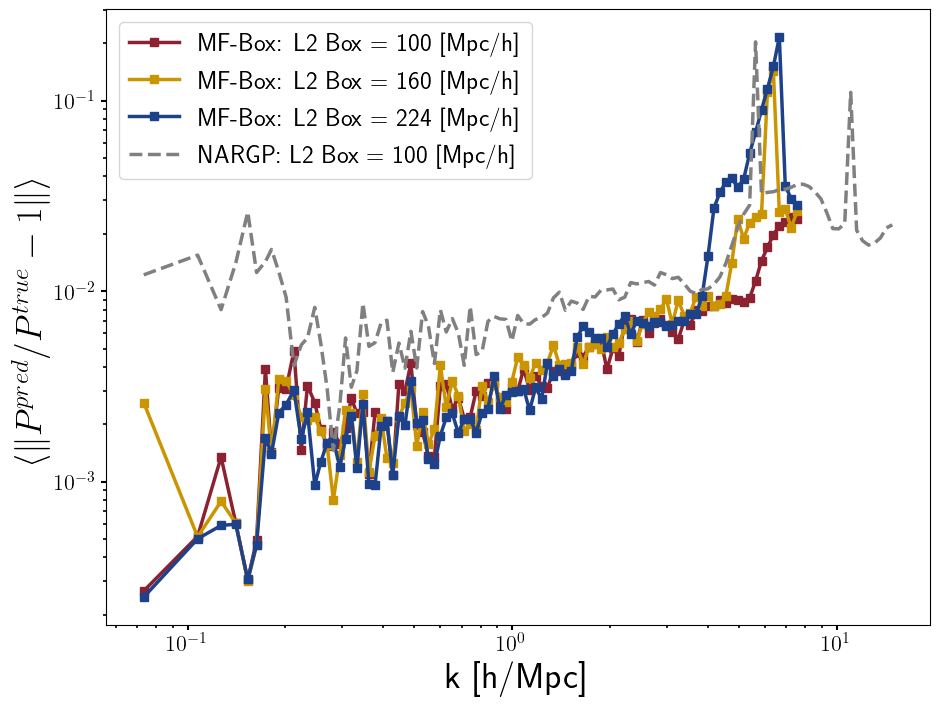

In [18]:
fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

kk = 10**vloaders.dgmgp_L60_H3_z0_1_2_slice_19.kf[0]

i = 0
for boxsize in boxsizes:
    if boxsize in [100, 160, 224]:
        ax.plot(
            kk,
            error_averge_z[i],
            's-',
            lw=2.5,
            color=colors[i],
            label=mf_box + ": L2 Box = {} [Mpc/h]".format(boxsize)
        )
        
        i+=1
        
## Include also NARGP
kk = 10**vloaders.nargp_L60_L2box100_H3_z0_1_2_slice_19.kf[0]
error_nargp = vloaders.nargp_L60_L2box100_H3_z0_1_2_slice_19.relative_errors
error_nargp = error_nargp.mean(axis=(0, 1))
ax.plot(
    kk,
    error_nargp,
    '--',
    lw=2.5,
    color="grey",
    label="NARGP: L2 Box = 100 [Mpc/h]"
)

ax.set_xlabel(r'k [h/Mpc]', fontsize=26)
ax.set_ylabel(r'$\langle\| P^{{pred}}/P^{{true}} - 1 \|\rangle$', fontsize=26)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
# ax.set_ylim([1e-4, 3e-1])
# ax.set_xlim([kf_test.min()* 0.8, kf_test.max() * 1.1])
fig.savefig(
    os.path.join(imgdir, "boxsize_dgmgp_all_z_versus_k.pdf"),
    bbox_inches='tight',
    pad_inches=0.075
)
plt.show()

#### # Different boxsize for L2; Error in k scales; split in z

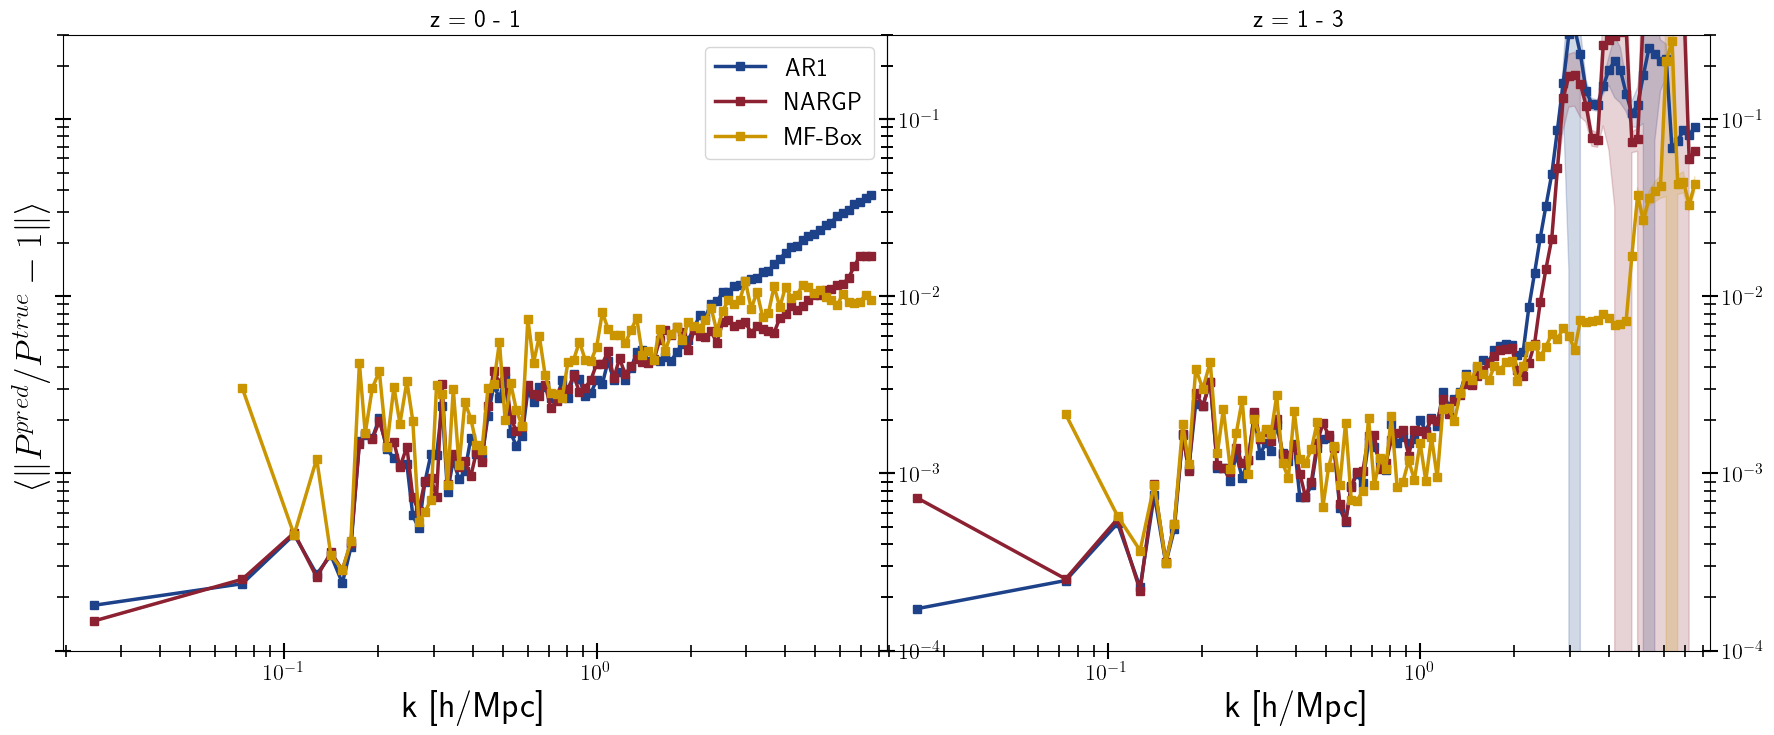

In [19]:


fig, axs = plt.subplots(figsize=(2*10.625, 8), nrows=1, ncols=2, sharey=True)

fig, ax = make_average_all_z_versus_k(
    vloaders.ar1_L60_H3_z0_1_2_slice_19,
    new_fig=False,
    color=colors[2],
    label="AR1",
    ax=axs[0],
    fig=fig,
    zmin=0.0,
    zmax=1.0,
)
fig, ax = make_average_all_z_versus_k(
    vloaders.nargp_L60_H3_z0_1_2_slice_19,
    new_fig=False,
    color=colors[0],
    label="NARGP",
    ax=ax,
    fig=fig,
    zmin=0.0,
    zmax=1.0,    
)

fig, ax = make_average_all_z_versus_k(
    vloaders.dgmgp_L60_L2box128_H3_z0_1_2_slice_19,
    new_fig=False,
    color=colors[1],
    label=mf_box,
    ax=ax,
    fig=fig,
    zmin=0.0,
    zmax=1.0,
)

fig, ax = make_average_all_z_versus_k(
    vloaders.ar1_L60_H3_z0_1_2_slice_19,
    new_fig=False,
    color=colors[2],
    label="AR1",
    ax=axs[1],
    fig=fig,
    zmin=1.0,
    zmax=3.1,
)
fig, ax = make_average_all_z_versus_k(
    vloaders.nargp_L60_H3_z0_1_2_slice_19,
    new_fig=False,
    color=colors[0],
    label="NARGP",
    ax=ax,
    fig=fig,
    zmin=1.0,
    zmax=3.1,
)

fig, ax = make_average_all_z_versus_k(
    vloaders.dgmgp_L60_L2box128_H3_z0_1_2_slice_19,
    new_fig=False,
    color=colors[1],
    label=mf_box,
    ax=ax,
    fig=fig,
    zmin=1.0,
    zmax=3.1,
)

# Martin style
axs[0].set_xlabel(r'k [h/Mpc]', fontsize=26)
axs[0].set_ylabel(r'$\langle\| P^{{pred}}/P^{{true}} - 1 \|\rangle$', fontsize=26)
axs[0].set_yscale('log')
axs[0].set_ylim([1e-4, 3e-1])
axs[0].set_xlim([kf_test.min()* 0.8, kf_test.max() * 1.1])

axs[1].set_xlabel(r'k [h/Mpc]', fontsize=26)
# axs[1].set_ylabel(r'$\langle\| P^{{pred}}/P^{{true}} - 1 \|\rangle$', fontsize=26)
axs[1].set_yscale('log')
axs[1].set_ylim([1e-4, 3e-1])
axs[1].set_xlim([kf_test.min()* 0.8, kf_test.max() * 1.1])

axs[0].tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)
axs[0].tick_params(which='minor', length=8)

axs[1].tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)
axs[1].tick_params(which='minor', length=8)

axs[0].legend()
axs[0].set_title("z = 0 - 1")
axs[1].set_title("z = 1 - 3")

axs[0].patch.set_facecolor('none')
axs[1].patch.set_facecolor('none')
fig.subplots_adjust(hspace=0, wspace=0)
# fig.savefig(
#     "/home/jibancat/Documents/Latex/mf_boxsize_paper/images/dgmgp_all_z_versus_k_split_scales.pdf",
#     bbox_inches='tight',
#     pad_inches=0.075
# )
plt.show()

## Randomize 3 selection

In [47]:
np.random.seed(123)

slices = [
    0, 1, 2,
    3, 4, 5,
    6, 7, 8,
    9, 10, 11,
    12, 13, 14,
    15, 16, 17,
    39, 40, 41,
    57, 58, 59,
]

In [48]:
slices_copy = np.copy(slices)

np.random.shuffle(slices_copy)

slices_copy

array([ 5, 41, 57, 39, 15,  8,  7, 11,  4,  3, 59, 12, 16,  9, 14, 40,  0,
        1, 10, 17,  6, 58,  2, 13])

Run:

5, 41, 57,  
39, 15,  8,  
7, 11,  4,  
3, 59, 12,  
16, 9, 14,  
40,  0, 1,  
10, 17,  6,  
58,  2, 13

## LFEmu randomized selection versus SLHD slices

In [75]:
from matter_multi_fidelity_emu.data_loader import PowerSpecs

# set a random number seed to reproducibility
np.random.seed(123)

from itertools import combinations

from trainset_optimize.optmize import TrainSetOptimize

In [76]:
def generate_data(folder: str = "data/processed/Matterpower_60_res128box256_3_res512box256_z0_ind-57-58-59/"):
    data = PowerSpecs(folder=folder)
    data.read_from_txt(folder)
    return data

In [77]:
# acquire data object, the text files 
data = generate_data()

i_fidelity = 0

X = data.X_train_norm[i_fidelity]
Y = data.Y_train[i_fidelity]

train_opt = TrainSetOptimize(X=X, Y=Y)

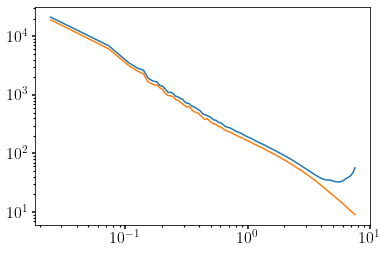

In [78]:
plt.loglog(10**data.kf, 10**data.Y_train[0][0])
plt.loglog(10**data.kf, 10**data.Y_train[1][0])

In [79]:
all_combinations = np.arange(60).reshape(20, 3)
all_combinations

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20],
       [21, 22, 23],
       [24, 25, 26],
       [27, 28, 29],
       [30, 31, 32],
       [33, 34, 35],
       [36, 37, 38],
       [39, 40, 41],
       [42, 43, 44],
       [45, 46, 47],
       [48, 49, 50],
       [51, 52, 53],
       [54, 55, 56],
       [57, 58, 59]])

In [80]:
%%capture
# loop over to get the least loss 2 indices
all_loss = []

for i,selected_index in enumerate(all_combinations):

    # need to convert to boolean array
    ind = np.zeros(num_samples, dtype=np.bool)
    ind[selected_index] = True

    loss = train_opt.loss(ind)

    print("iteration:", i)

    all_loss.append(loss)

In [81]:
# find the set of indices best minimize the loss
selected_index = np.array(all_combinations[np.argmin(all_loss)])

selected_index

array([57, 58, 59])

Randomized selection

In [86]:
# acquire data object, the text files 
data = generate_data()

i_fidelity = 0

X = data.X_train_norm[i_fidelity]
Y = data.Y_train[i_fidelity]

train_opt = TrainSetOptimize(X=X, Y=Y)

# set a random number seed to reproducibility
np.random.seed(123)


shuffled_combinations = np.copy(all_combinations).ravel()
np.random.shuffle(shuffled_combinations)

shuffled_combinations = shuffled_combinations.reshape(20, 3)

In [87]:
%%capture
# loop over to get the least loss 2 indices
shuffled_loss = []

for i,selected_index in enumerate(shuffled_combinations):

    # need to convert to boolean array
    ind = np.zeros(num_samples, dtype=np.bool)
    ind[selected_index] = True

    loss = train_opt.loss(ind)

    print("iteration:", i)

    shuffled_loss.append(loss)

In [101]:
np.log10(0.001), np.log10(0.3)

(-3.0, -0.5228787452803376)

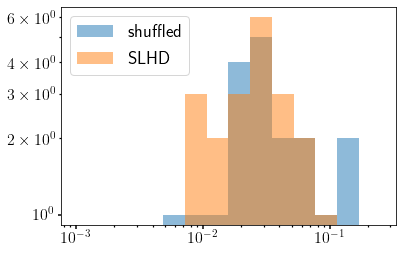

In [106]:
bins = 10**np.linspace(-3, -0.6, num=15)

fig, ax = plt.subplots()

ax.hist(shuffled_loss, log=True, bins=bins, label="shuffled", alpha=0.5)
ax.hist(all_loss, log=True, bins=bins, label="SLHD", alpha=0.5)

ax.set_xscale("log")

ax.legend()

## HFEmu SLHD versus ordinary LHD

In [107]:
# acquire data object, the text files 
data = generate_data("data/processed/Matterpower_60_res128box256_18_res512box256_z0_ind-0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-57-58-59/")

i_fidelity = 1

X = data.X_train_norm[i_fidelity]
Y = data.Y_train[i_fidelity]

# ordinary LHD